# Study of the synonymous mutations

Created: **19/07/18**  
Last modified: **09/08/18**

**Goal:** this study will focus only on the `synonymous_SNV` mutations, trying first to filter the non-somatic synonymous mutations and then to study the reccurent synonymous mutations. This notebook follows the methodology of the `coding_mutations_analysis.ipynb` notebook.  
This notebook is divided in two parts:
* **1. The `label` feature: coding_somatic vs synonymous**: introduce a new feature to class the mutations as coding_somatic or synonymous. The idea is to filter the set of synonymous mutations by comparing their parameters to a set of known somatic mutations parameters.
* **2. The `mut_key` feature: study of reccurent mutations**: study the reccurence of synonymous mutations.

**Refs:**
* `coding_mutations_analysis.ipynb`

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-label-feature:-coding_somatic-vs-synonymous" data-toc-modified-id="The-label-feature:-coding_somatic-vs-synonymous-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>label</code> feature: coding_somatic vs synonymous</a></span><ul class="toc-item"><li><span><a href="#Creating-the-feature" data-toc-modified-id="Creating-the-feature-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the feature</a></span></li><li><span><a href="#Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio" data-toc-modified-id="Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the <code>frequency_in_normals</code>, <code>t_vaf</code> and <code>strand_ratio</code></a></span></li><li><span><a href="#Comparison-of-Kaviar_AF" data-toc-modified-id="Comparison-of-Kaviar_AF-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparison of <code>Kaviar_AF</code></a></span></li><li><span><a href="#Comparison-of-cosmic_count" data-toc-modified-id="Comparison-of-cosmic_count-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison of <code>cosmic_count</code></a></span></li></ul></li><li><span><a href="#The-mut_key-feature:-study-of-reccurent-mutations" data-toc-modified-id="The-mut_key-feature:-study-of-reccurent-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The <code>mut_key</code> feature: study of reccurent mutations</a></span><ul class="toc-item"><li><span><a href="#Identify-the-reccurent-mutations" data-toc-modified-id="Identify-the-reccurent-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify the reccurent mutations</a></span></li><li><span><a href="#Sudy-the-reccurent-mutations-genes" data-toc-modified-id="Sudy-the-reccurent-mutations-genes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sudy the reccurent mutations genes</a></span></li><li><span><a href="#Study-the-outliers" data-toc-modified-id="Study-the-outliers-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Study the outliers</a></span></li></ul></li></ul></div>

***

In [9]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [10]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

[1] "Hugo_Symbol"          "Chromosome"           "Start_Position"      
 [4] "End_Position"         "Consequence"          "Variant_Type"        
 [7] "Reference_Allele"     "Tumor_Seq_Allele2"    "Tumor_Sample_Barcode"
[10] "cDNA_change"          "HGVSp_Short"          "t_depth"             
[13] "t_vaf"                "t_alt_count"          "n_depth"             
[16] "n_vaf"                "n_alt_count"          "t_ref_plus_count"    
[19] "t_ref_neg_count"      "t_alt_plus_count"     "t_alt_neg_count"     
[22] "confidence_class"     "sample_coverage"      "mut_key"             
[25] "sample_mut_key"       "frequency_in_normals" "Kaviar_AF"           
[28] "cosmic_count"

Warning message in KernSmooth::bkde2D(x, bandwidth = bandwidth, gridsize = nbin, :
“Binning grid too coarse for current (small) bandwidth: consider increasing 'gridsize'”

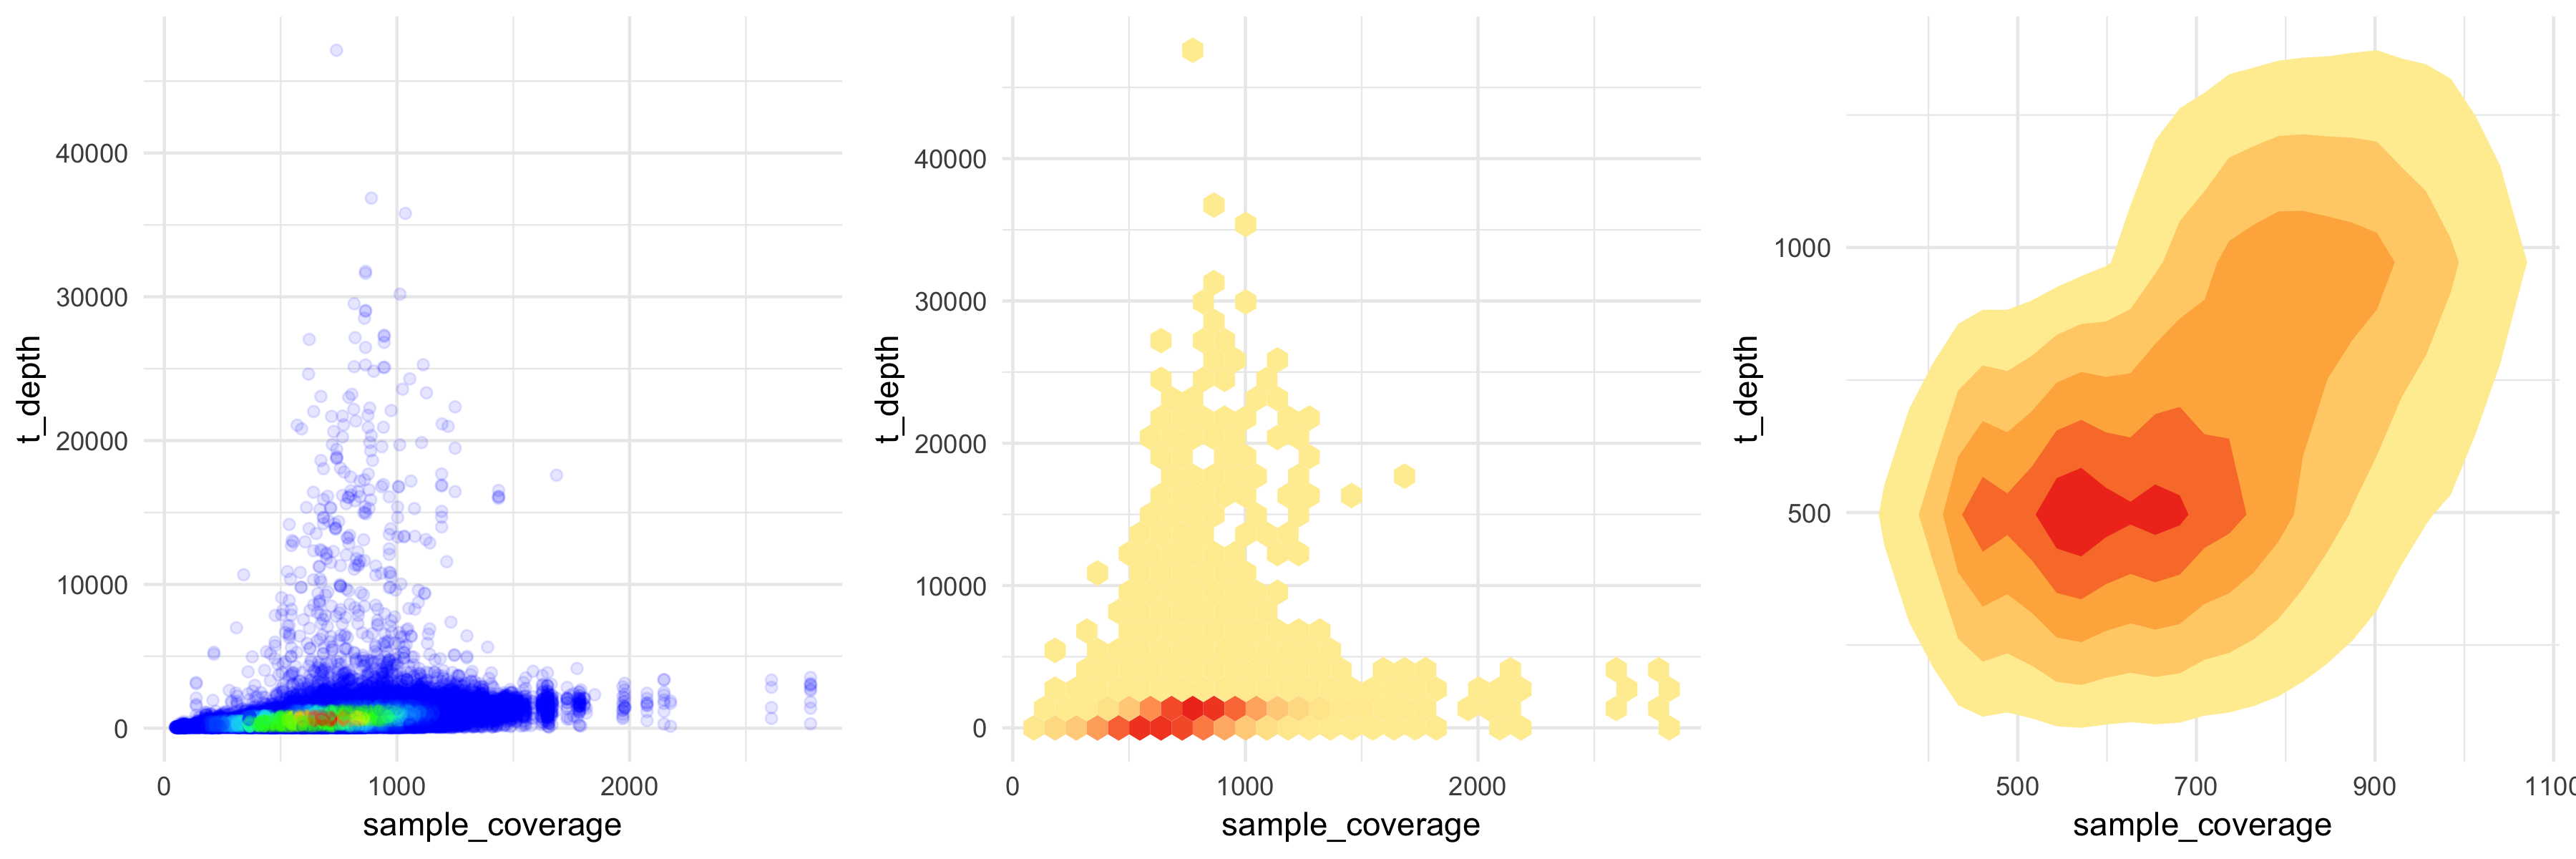

In [11]:
colnames(impact)


plot_density_2d(impact, "sample_coverage", "t_depth")

## The `label` feature: coding_somatic vs synonymous

The `synonymous_SNV` mutations have automatically been classified as `UNKNOWN` so we don't know which one are somatic or non-somatic mutations. However, the coding mutations have been curated, and we know which one of them are somatic. Thus, we can take the somatic coding mutations as a reference of mutations that are somatic. For example, comparing the `frequency_in_normals` for `synonymous_SNV` mutations and somatic coding mutations could reveal a difference and help us to filter the `synonymous_SNV` mutations that are somatic from the one that are non-somatic.  

Unfortunately, this study will show that the `frequency_in_normals`, `t_vaf` and `strand_bias` features won't be relevant to filter the `synonymous_SNV` mutations. However, the `Kaviar_AF` feature could help us!

### Creating the feature

We create a new feature `label`:
* A mutation has `label = synonymous` if `Consequence = synonymous_SNV`
* A mutation has `label = coding_somatic` if it is a coding mutation and `confidence_class = AUTO_OK | MANUAL_OK`.

In [12]:
impact <- impact[(impact$Consequence == "synonymous_SNV") |
                 (impact$Consequence != "synonymous_SNV" & (impact$confidence_class == "AUTO_OK" |
                                                            impact$confidence_class == "MANUAL_OK")),]
impact$label <- "coding_somatic"
impact$label[(impact$Consequence == "synonymous_SNV")] <- "synonymous"

addmargins(table(impact$label, impact$confidence_class), margin = 2)
100 * nrow(impact[impact$label == "synonymous",]) / nrow(impact) # percentage of synonymous mutations

AUTO_OK MANUAL_OK UNKNOWN Sum   
  coding_somatic 180763  6335          0   187098
  synonymous          0     0      50010    50010

[1] 21.09165

The dataset is unbalanced with 50,010 synonymous mutations ($21.1\%$ of the samples) vs 187,098 somatic mutations ($78.9\%$ of the samples).

### Comparison of the `frequency_in_normals`, `t_vaf` and `strand_ratio`

We create the `strand_ratio` feature:

In [13]:
impact$strand_ratio <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                       pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `frequency_in_normals`, `tvaf` and `strand_ratio` for the coding vs synonymous `label` (warning the first and last plot have a sqrt x and sqrt y scale):

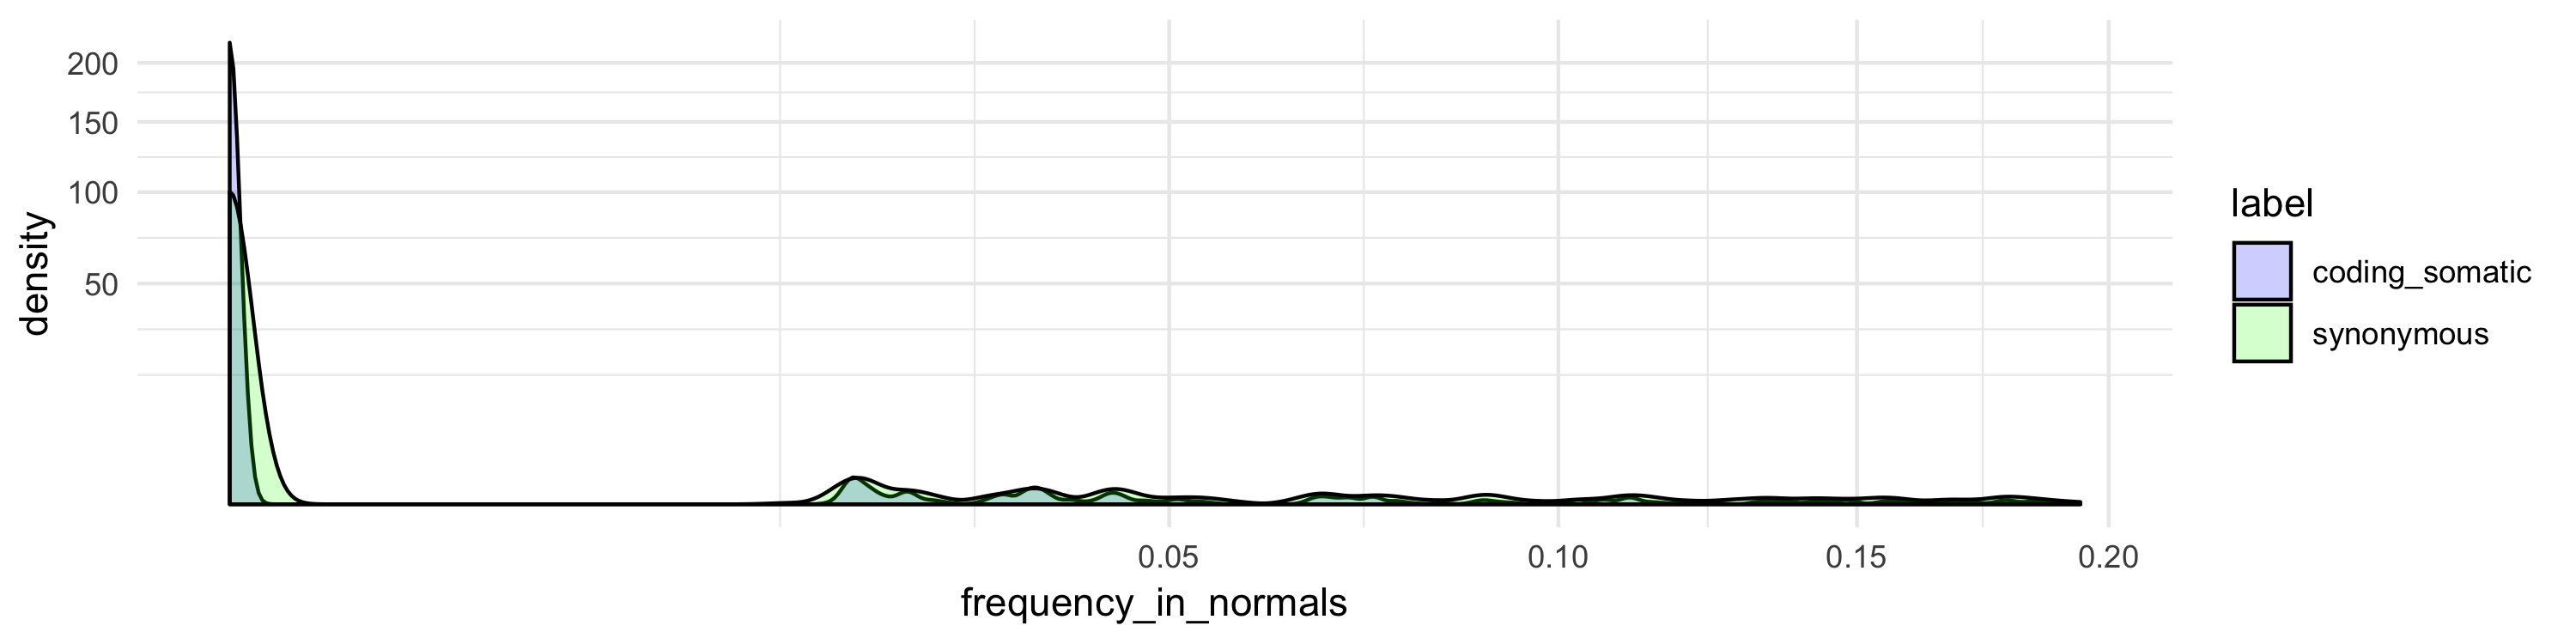

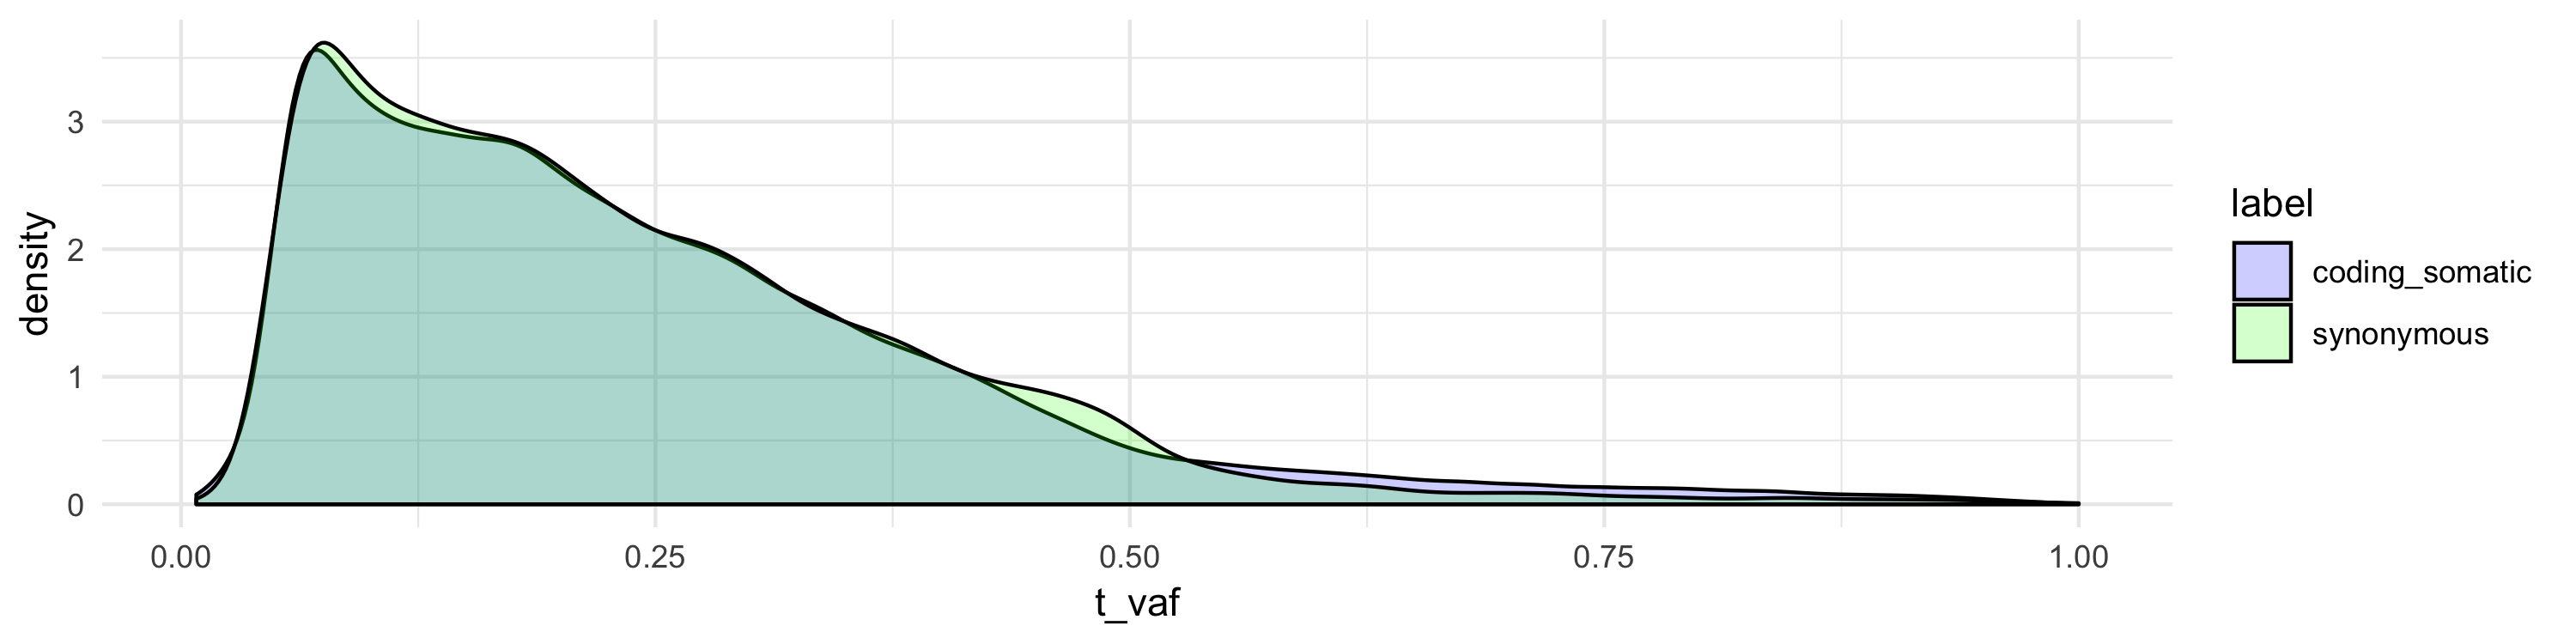

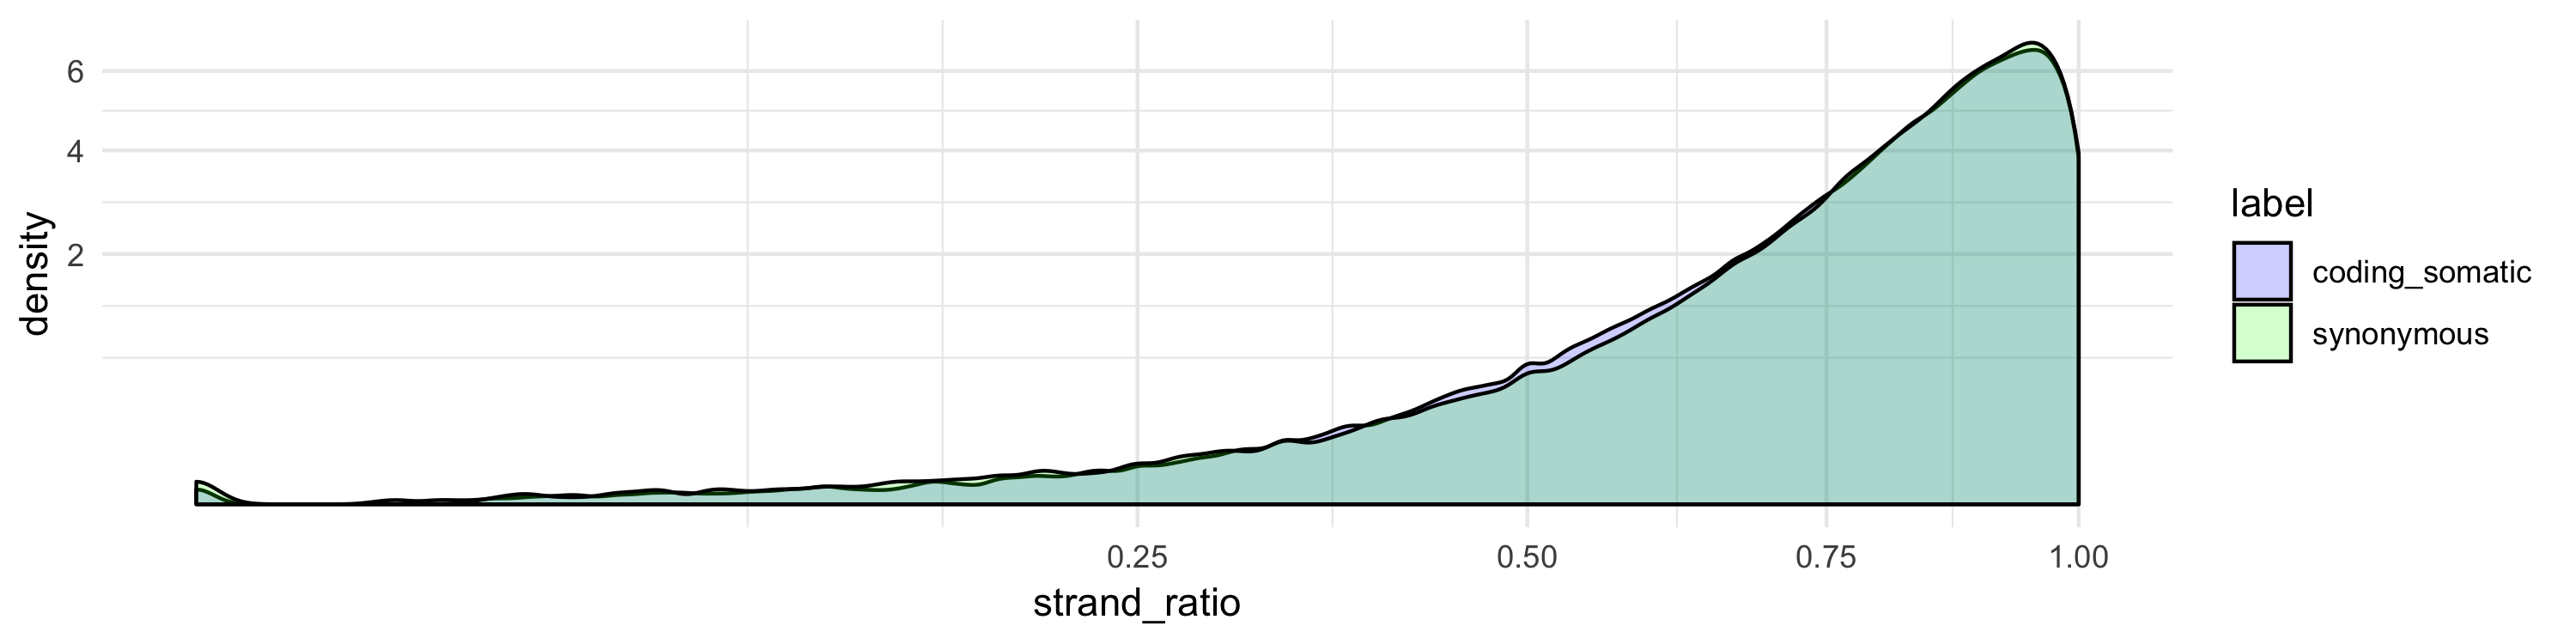

In [14]:
plot_density(impact, "frequency_in_normals", "label", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()
plot_density(impact, "t_vaf", "label", height = 2.5)
plot_density(impact, "strand_ratio", "label", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()

The distributions are almost identical in every plot. Wee see a little bump at `t_vaf` $\approx 0.5$ for the synonymous mutations, most likely the germline part of it but it is really not pronounced.

Below is an attempt to plot the `strand_ratio` vs the `t_vaf` to separate the germline (`t_vaf` $\approx 0.5$ and high `strand_ratio`) from the artefact (low `t_vaf` and low `strand_ratio`), but nothing really discriminant was found.

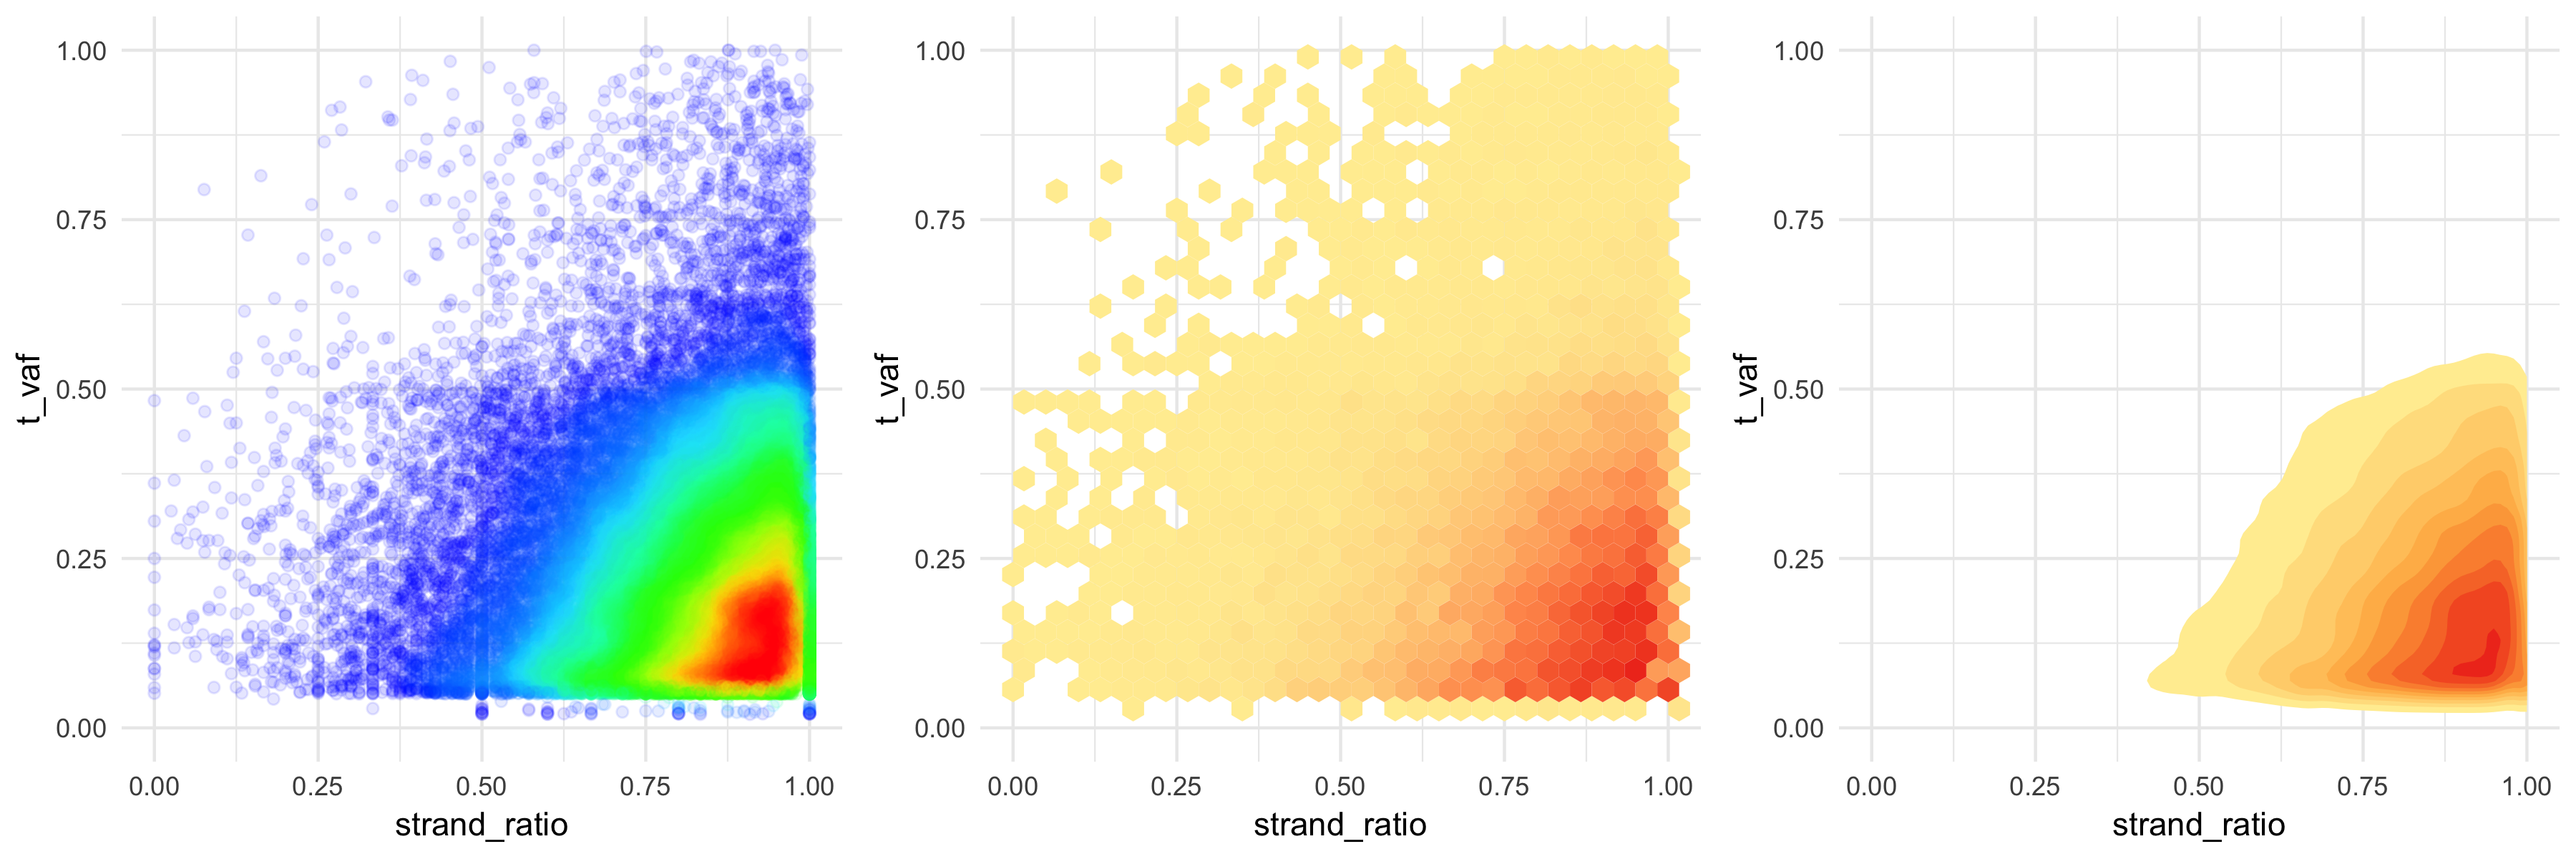

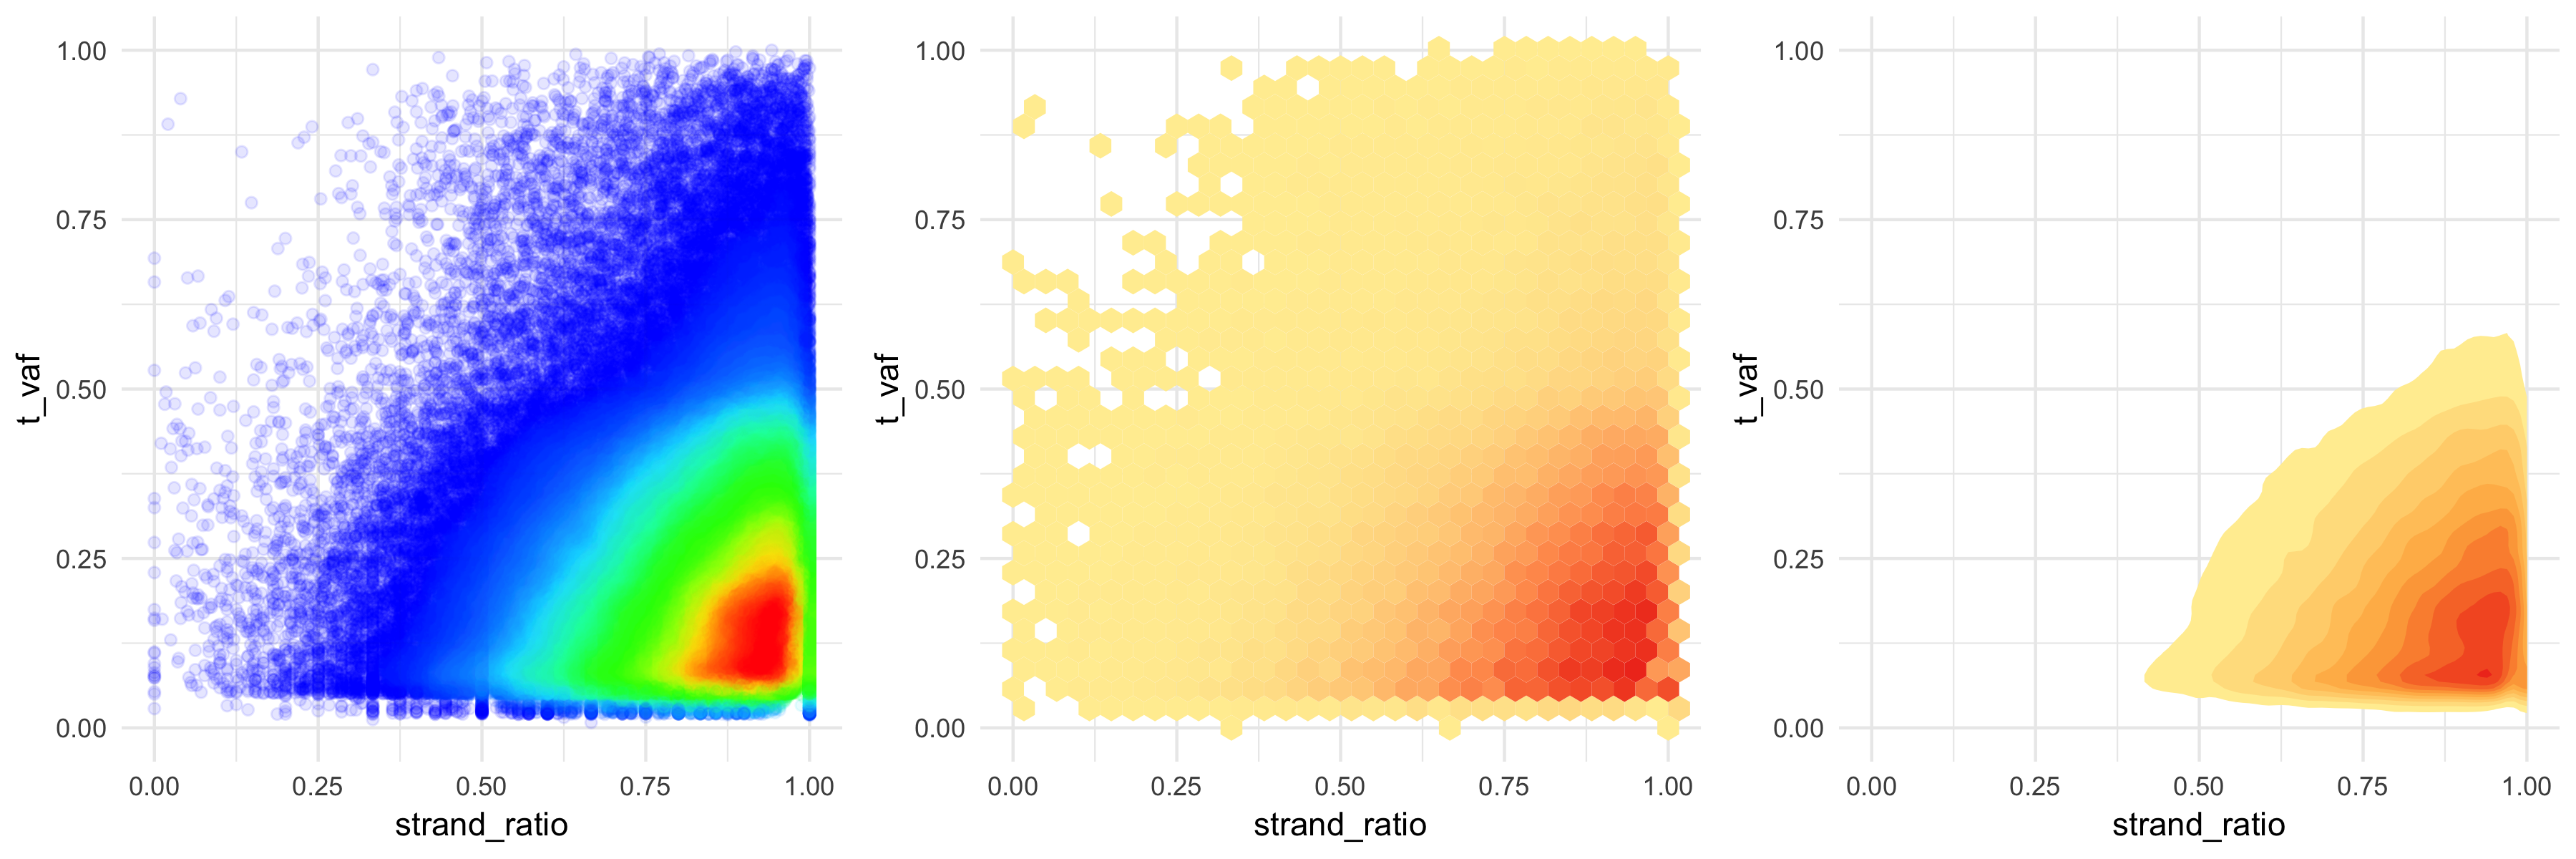

In [15]:
plot_density_2d(impact[impact$label == "synonymous",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))
plot_density_2d(impact[impact$label == "coding_somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the coding vs synonymous `label` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `Kaviar_AF` ie 26.64% of the data):

[1] "63176 over 237108 (26.64%)"

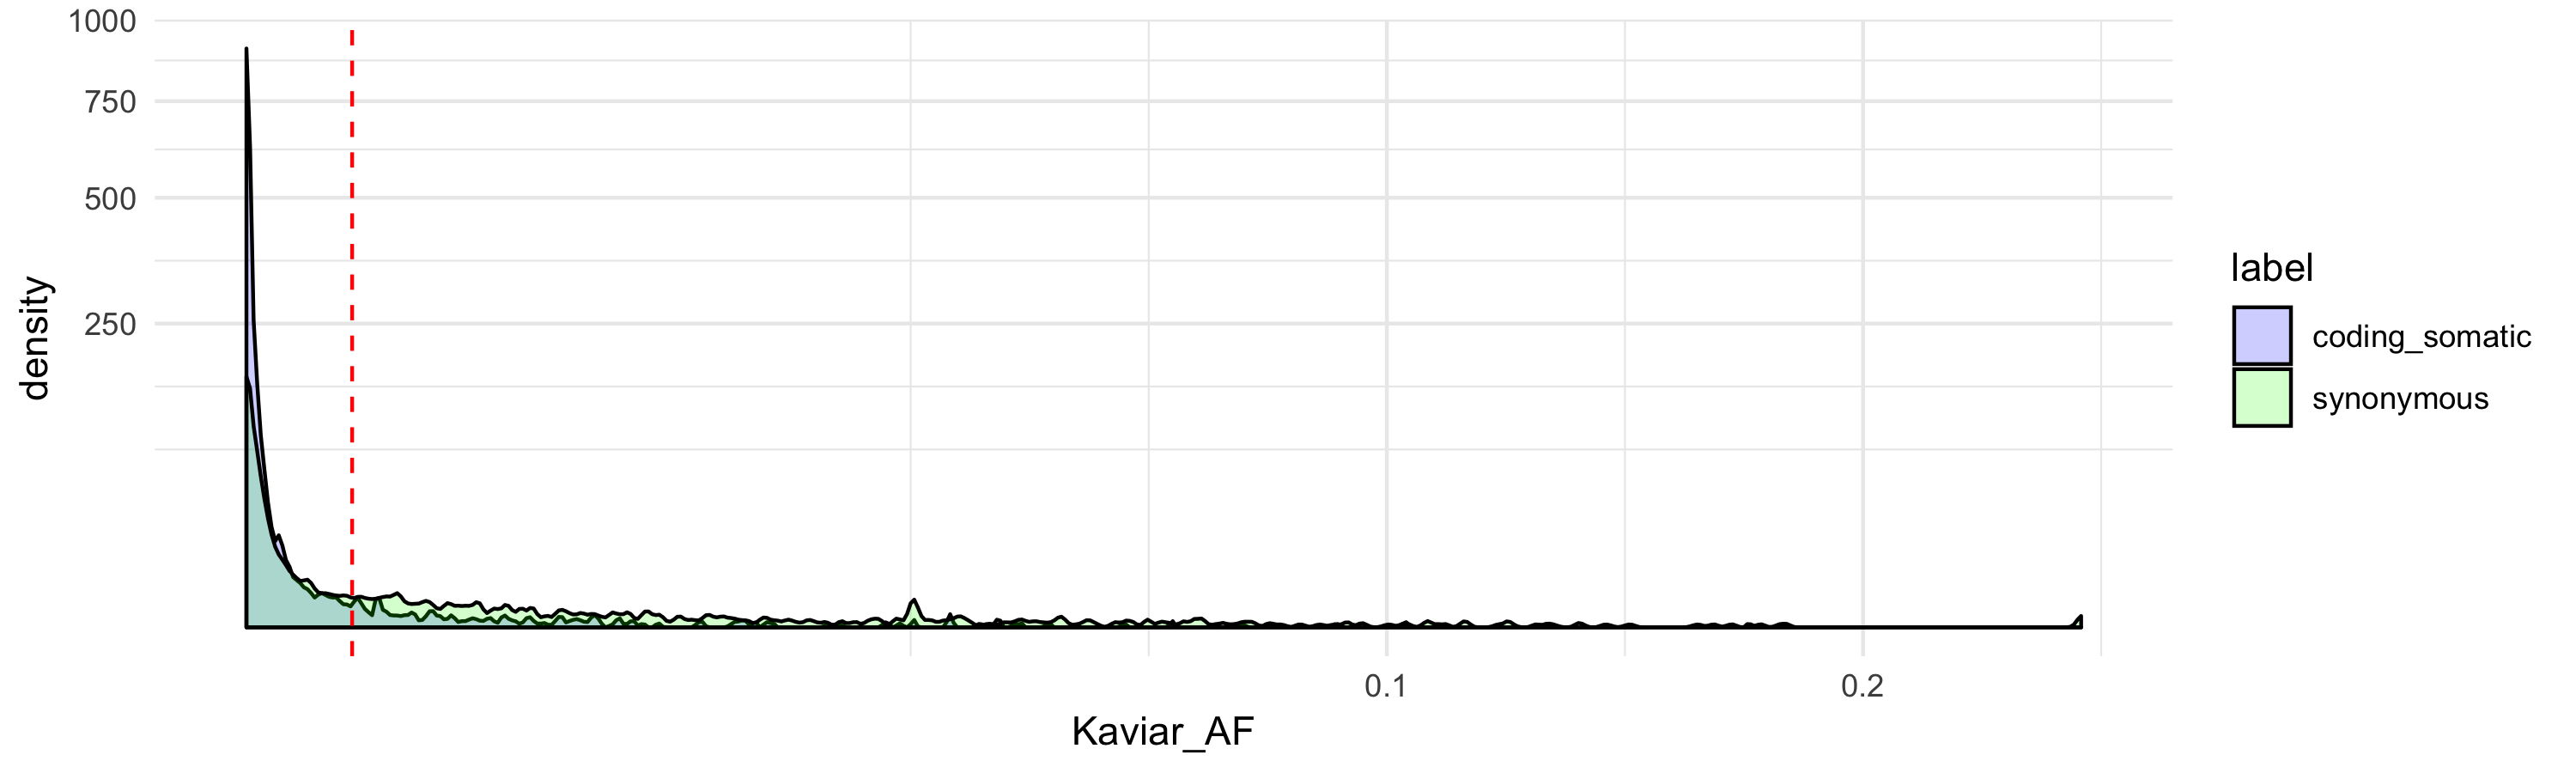

In [16]:
print_count_and_proportion(impact[impact$Kaviar_AF != 0,], impact)
plot_density(impact[impact$Kaviar_AF != 0,], "Kaviar_AF", "label", lines = 0.001) + scale_x_sqrt() + scale_y_sqrt()

The synonymous mutations present a heavier `Kaviar_AF` tail, which are likely to be the artefacts call.

In [17]:
summary(impact[impact$label == "coding_somatic",]$Kaviar_AF)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.000026 0.000000 0.172999 

In [18]:
summary(impact[impact$label == "synonymous",]$Kaviar_AF)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0005996 0.0000065 0.2572410 

In [19]:
100 * nrow(impact[impact$label == "coding_somatic" &
                  impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$label == "coding_somatic",])
100 * nrow(impact[impact$label == "synonymous" &
                  impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$label == "synonymous",])

[1] 0.2768603

[1] 4.173165

We are going to set a threshold on the `Kaviar_AF` parameter to try to curate the `synonymous` mutations, even if the threshold is a bit severe and will loose some somatic synonymous, we should still be able to work on a sufficient amount of `synonymous` mutations. The threshold will be set at 0.001 (see red line on the plot above).

In [20]:
impact <- impact[impact$label != "synonymous" |
                 (impact$label == "synonymous" & impact$Kaviar_AF <= 0.001),]

### Comparison of `cosmic_count`

Distribution of `cosmic_count` for the coding vs synonymous `albel` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `cosmic_count` ie 21,88% of the data):

[1] "51600 over 235021 (21.96%)"

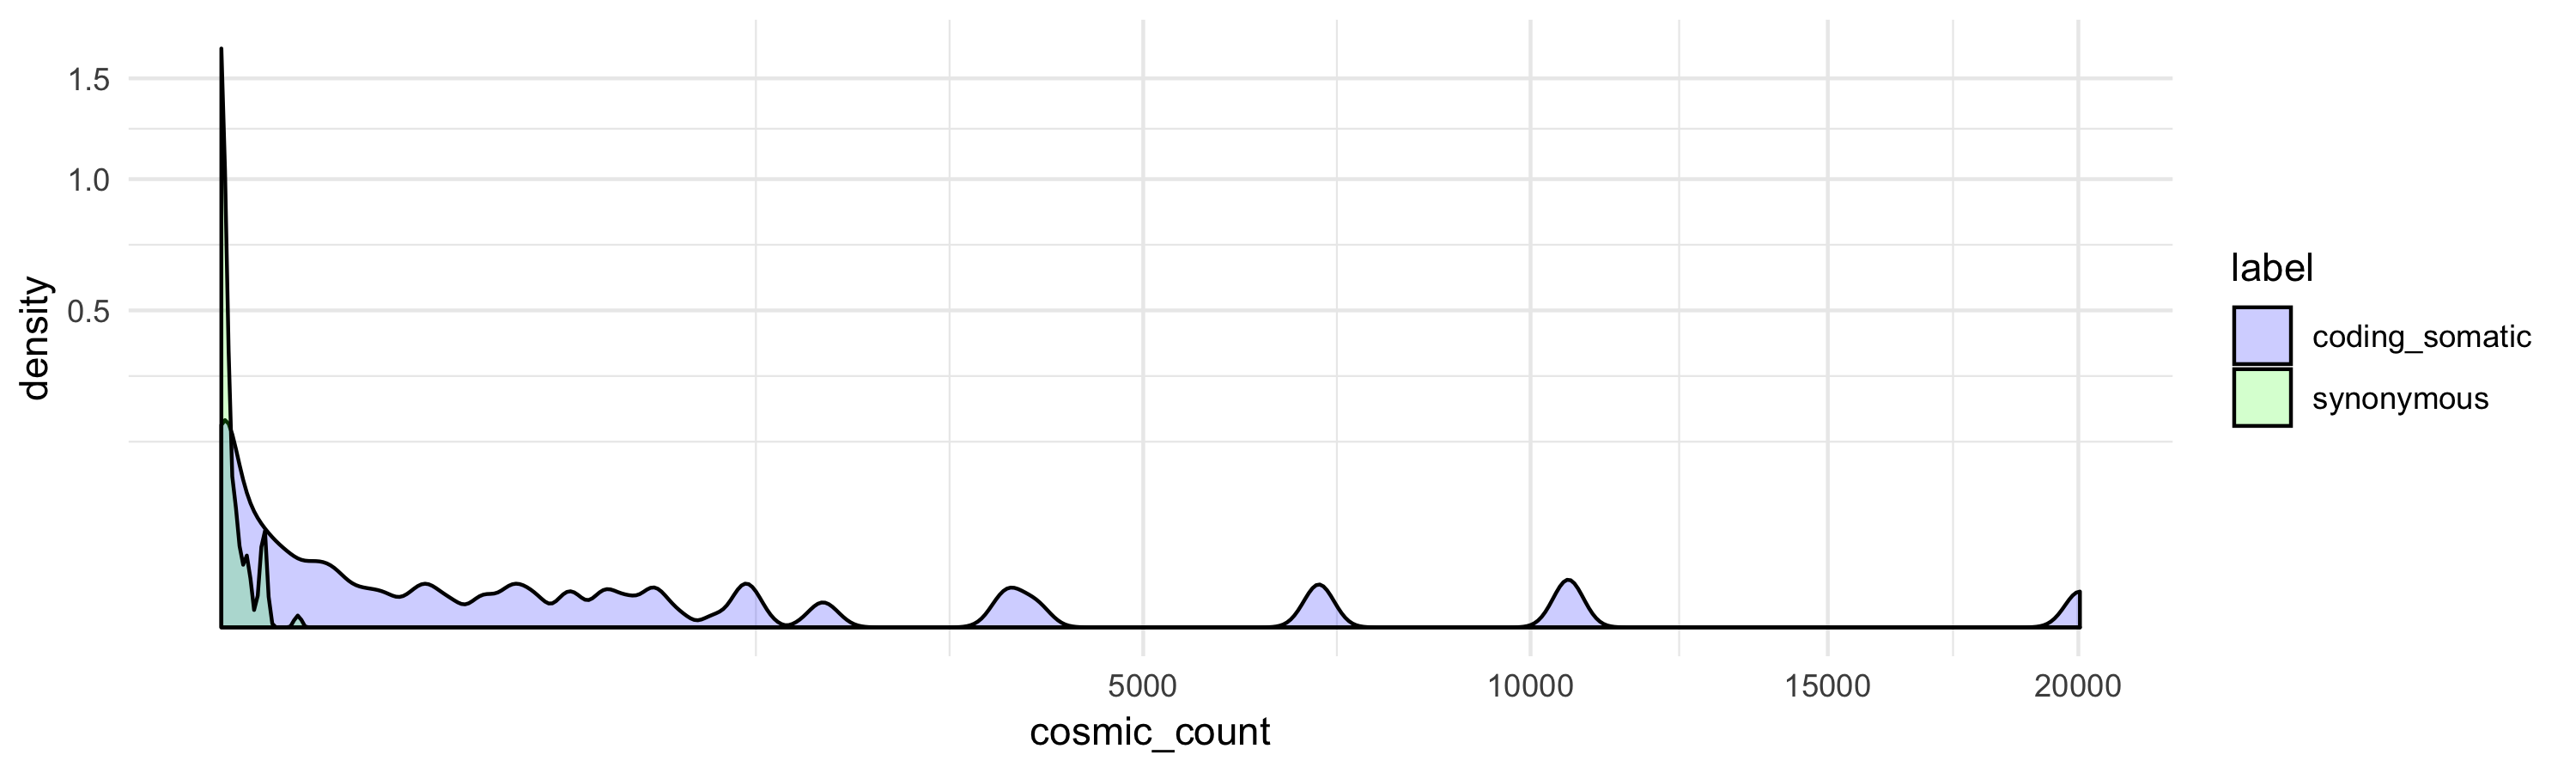

In [21]:
print_count_and_proportion(impact[impact$cosmic_count != 0,], impact)
plot_density(impact[impact$cosmic_count != 0,], "cosmic_count", "label") + scale_x_sqrt() + scale_y_sqrt()

As expected the `synonymous` mutations have a really low `cosmic_count`.

In [22]:
summary(impact[impact$label == "synonymous",]$cosmic_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1262  0.0000 46.0000 

## The `mut_key` feature: study of reccurent mutations

In [23]:
impact_syn <- impact[impact$label == "synonymous",] # keep only the synonymous mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [24]:
head(impact_syn$mut_key)
length(unique(impact_syn$mut_key)) # number of different keys e.g. number of different mutations

[1] "1_27101572_C_G"  "19_5244030_C_G"  "1_162740271_C_T" "3_134977903_C_T"
[5] "X_123197875_C_A" "3_189612072_C_T"

[1] 38968

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [25]:
# create a patient id (no problem will be caused by 'None-T01-IM6' which will become 'None-T01-')
impact_syn$patient_id <- substr(impact_syn$Tumor_Sample_Barcode, 1, 9)
head(unique(impact_syn$patient_id))

[1] "P-0000012" "P-0000026" "P-0000027" "P-0000030" "P-0000039" "P-0000037"

In [26]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact_syn %>% group_by(patient_id) %>%
                                                                   select(patient_id, mut_key, Hugo_Symbol) %>%
                                                                   filter(! duplicated(mut_key)))
nrow(impact_syn)
nrow(impact_unique_mut_keys_per_patient)

[1] 47923

[1] 46275

In [27]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(),
                                                                               Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key        count Hugo_Symbol
1 1_11168249_G_A 1     MTOR       
2 1_11168276_C_G 1     MTOR       
3 1_11168276_C_T 1     MTOR       
4 1_11168327_A_G 1     MTOR       
5 1_11168339_C_T 1     MTOR       
6 1_11169351_G_A 1     MTOR

In [28]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "13% ( 4921) of the keys are shared by at least  2 samples [26% (12228) of the rows concerned]"
[1] " 3% ( 1226) of the keys are shared by at least  3 samples [10% ( 4838) of the rows concerned]"
[1] " 1% (  198) of the keys are shared by at least  5 samples [ 3% ( 1535) of the rows concerned]"
[1] " 0% (   32) of the keys are shared by at least 10 samples [ 1% (  568) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples (warning this is a sqrt x and y scale):

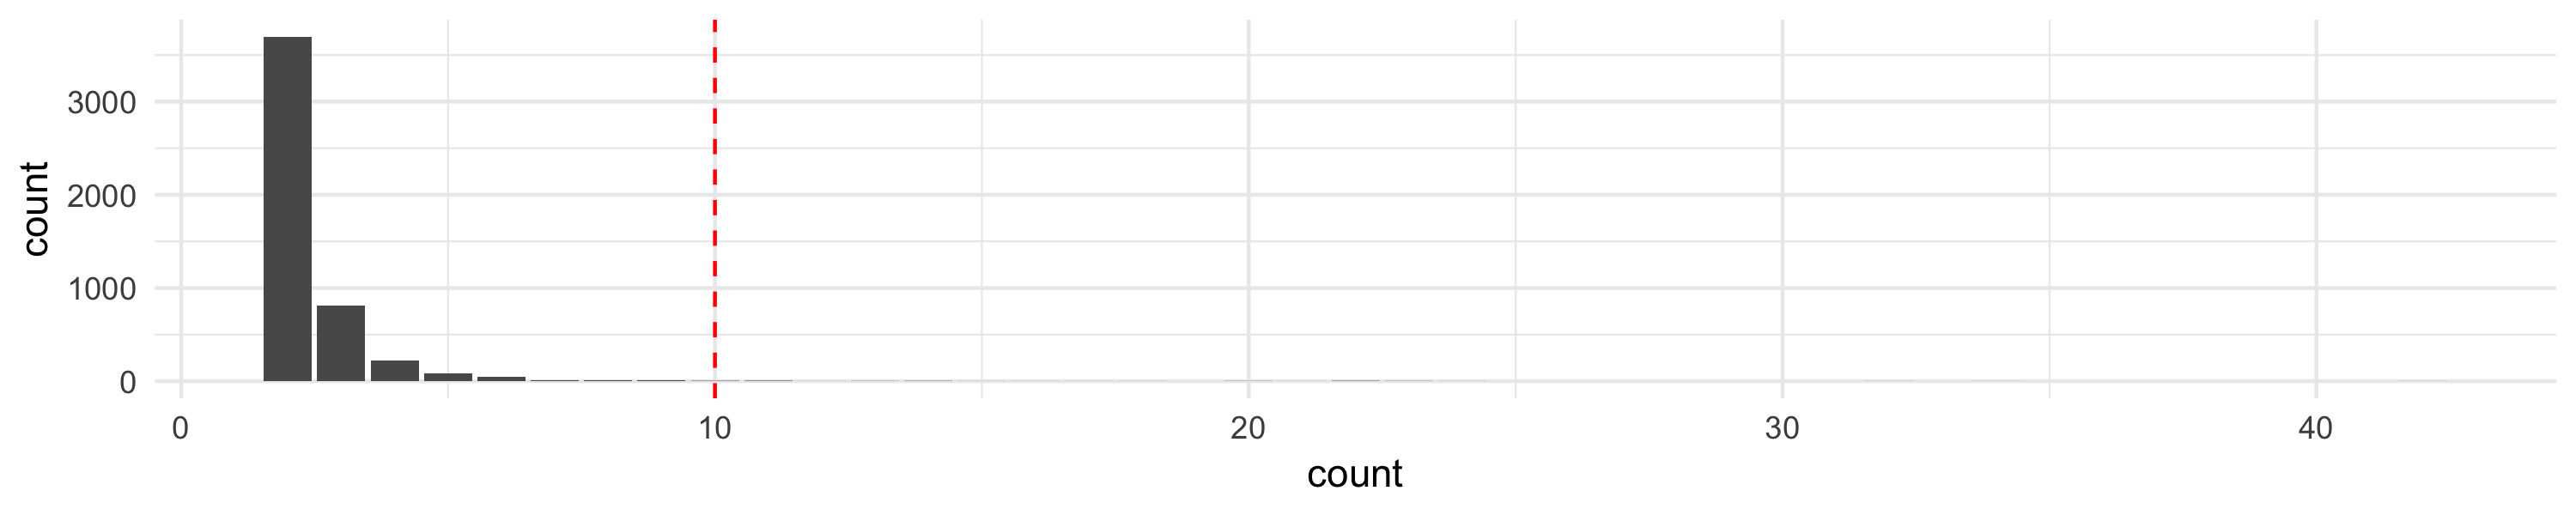

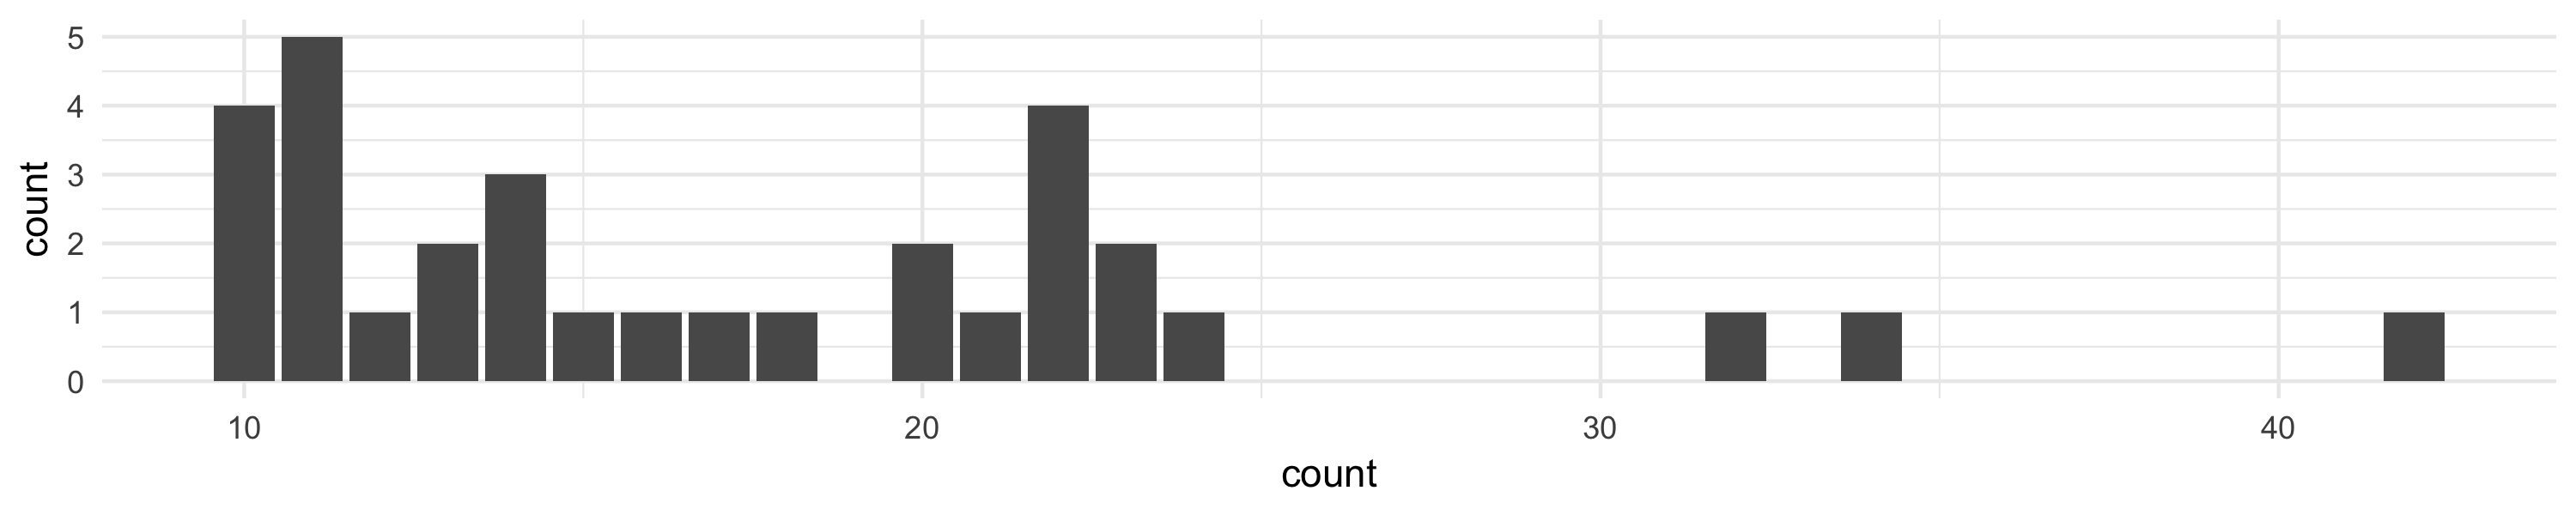

In [29]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(x = count)) + geom_vline(aes_(xintercept = 10), linetype = "dashed", color = "red")
ggplot(repeated_key[repeated_key$count >= 10,]) + geom_bar(aes(x = count))

### Sudy the reccurent mutations genes

In [30]:
length(unique(repeated_key$Hugo_Symbol))

[1] 448

In [31]:
head(repeated_key)

mut_key        count Hugo_Symbol
7  1_11169411_C_T 2     MTOR       
11 1_11169776_G_A 2     MTOR       
20 1_11181321_C_G 3     MTOR       
27 1_11182069_G_A 2     MTOR       
30 1_11182162_G_A 2     MTOR       
38 1_11184683_G_A 2     MTOR

Here is a plot of the genes that are the most mutated **accross the mutation keys**:

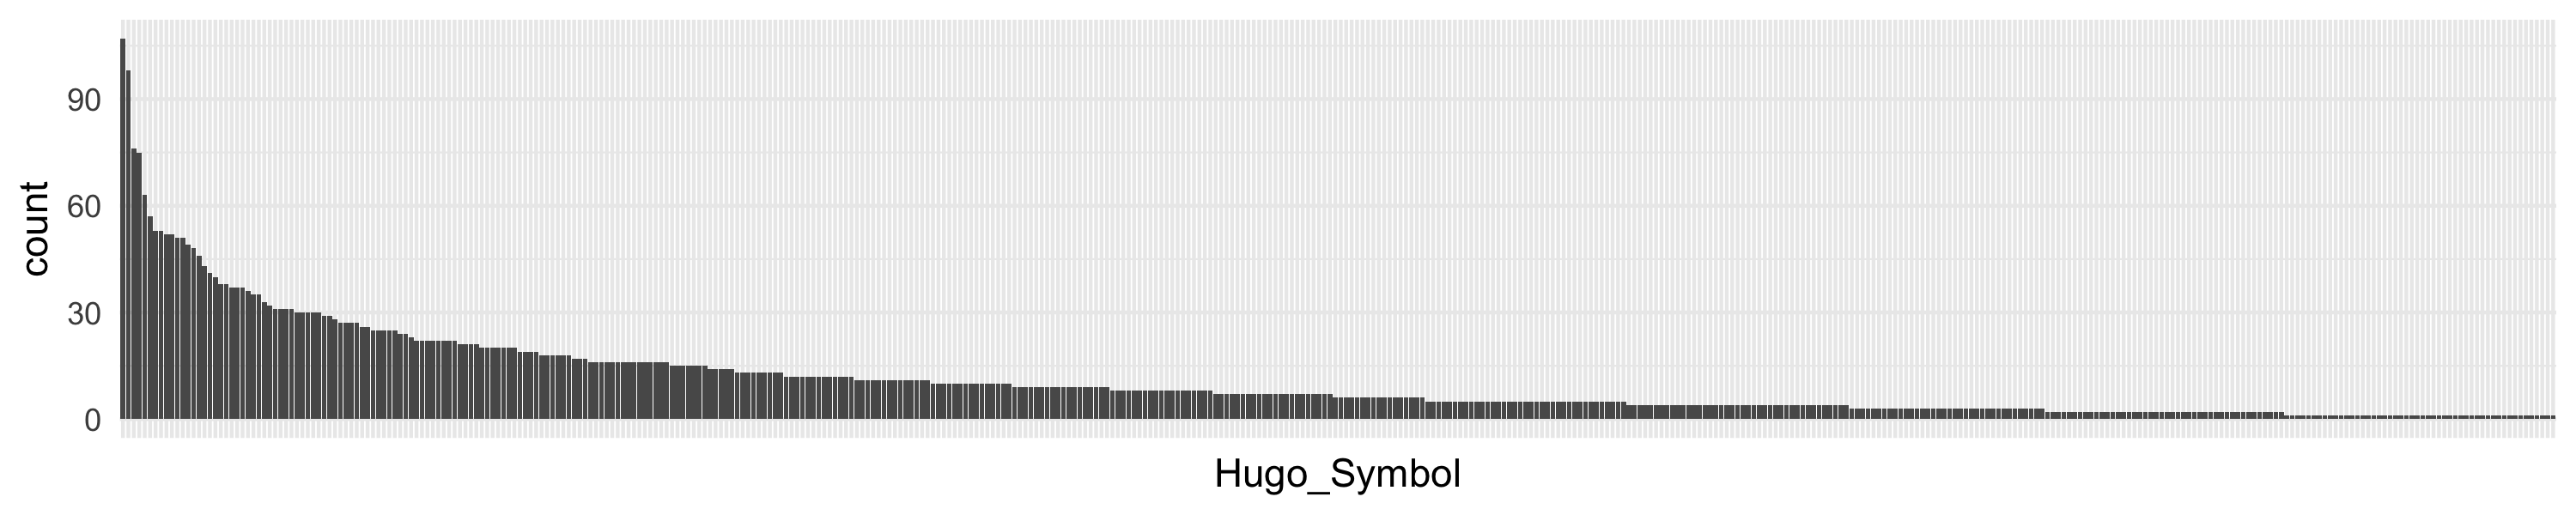

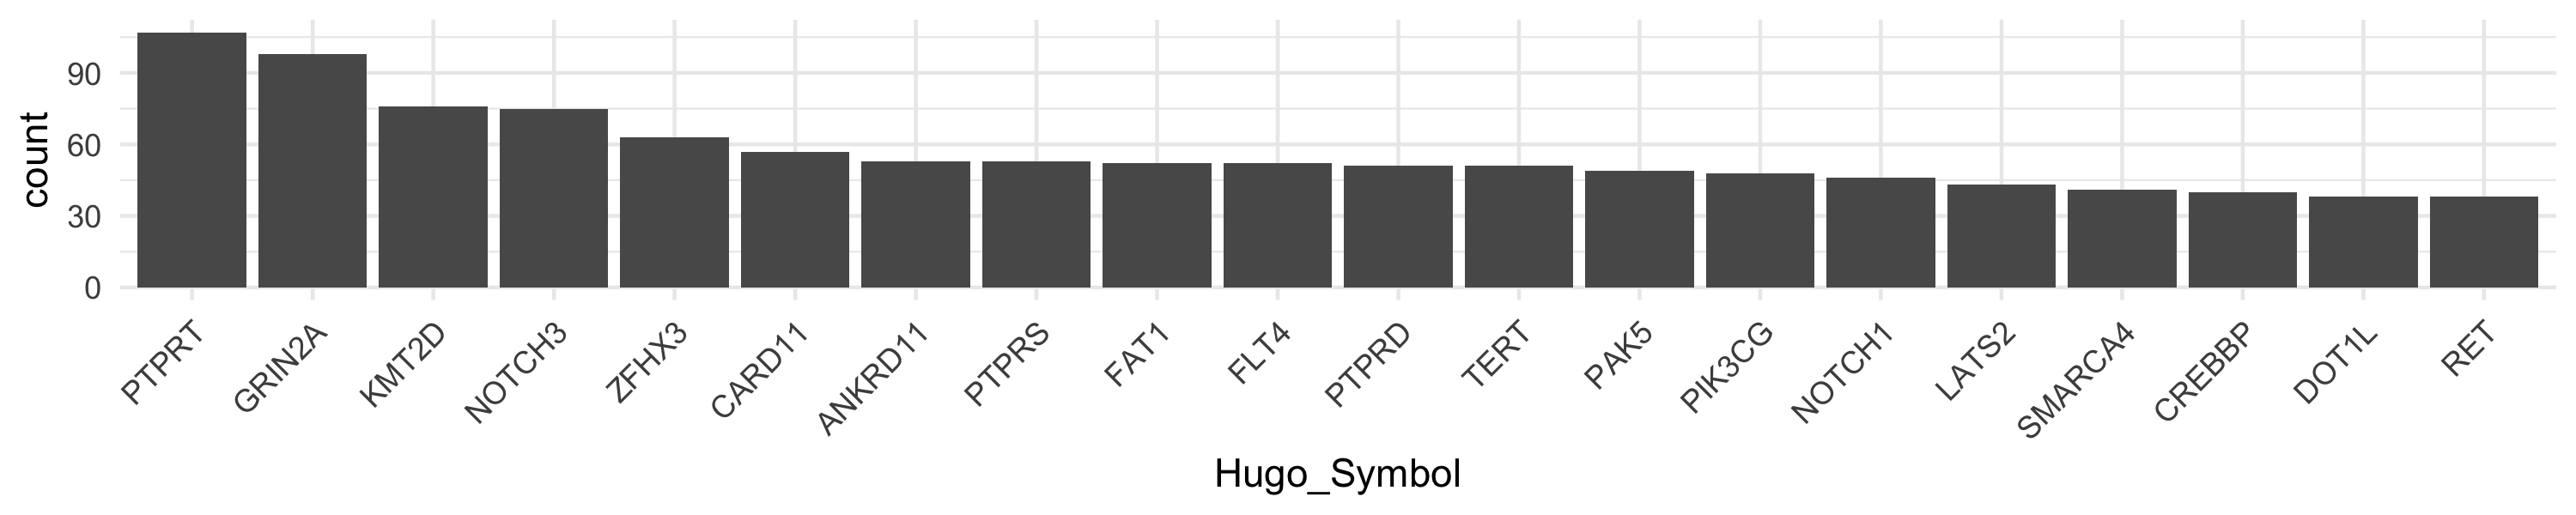

In [32]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

Here is a plot of the genes that are the most mutated **accross the rows**:

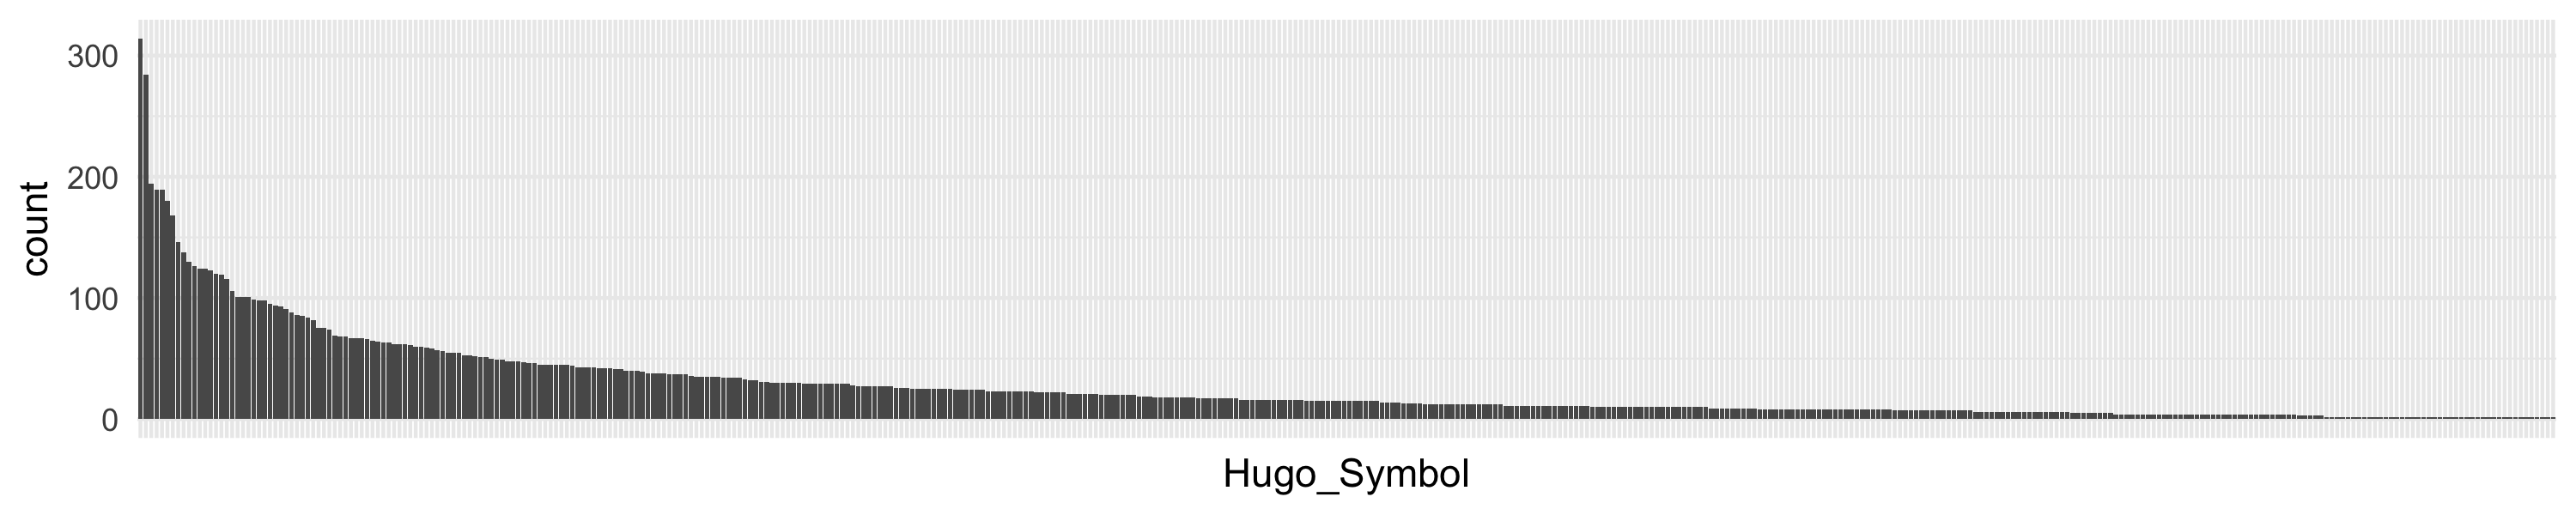

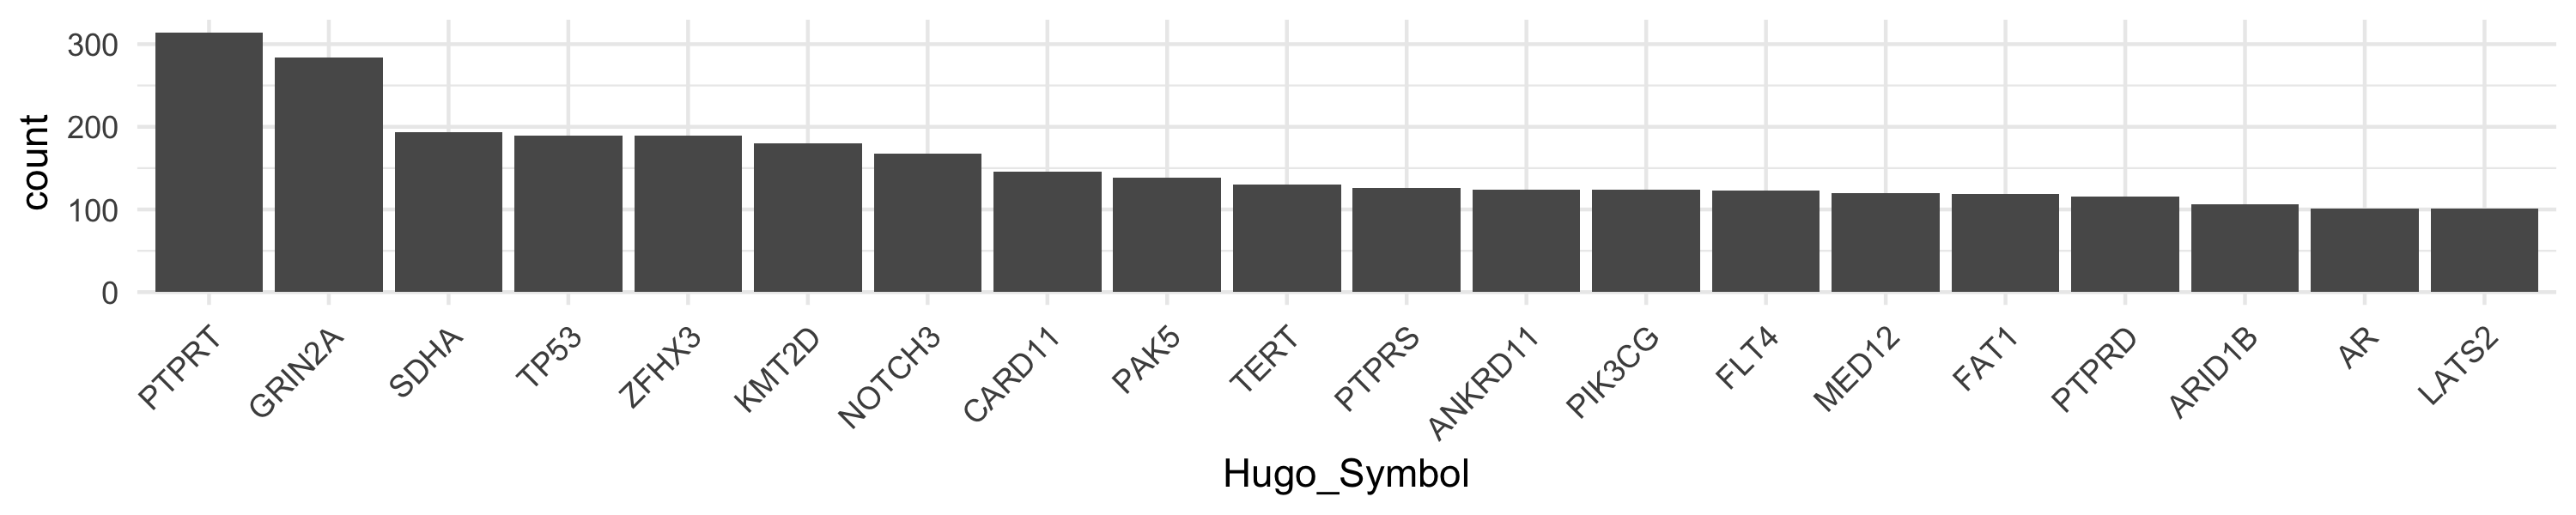

In [33]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

In [34]:
for (gene_name in c("PTPRT", "GRIN2A", "SDHA", "TP53")) {
    print(print_count_and_proportion(impact[impact$Hugo_Symbol == gene_name & impact$Consequence == "synonymous_SNV",],
                                     impact[impact$Hugo_Symbol == gene_name,]))
}

[1] "660 over 2144 (30.78%)"
[1] "573 over 1683 (34.05%)"
[1] "274 over 469 (58.42%)"
[1] "292 over 11391 (2.56%)"


More study....

### Study the outliers

Let's study the outliers present in more than 20 samples:

In [73]:
outliers <- repeated_key %>% arrange(-count) %>%
                             filter(count >= 20) %>%
                             mutate(rank = row_number()) %>%
                             select(rank, count, mut_key, Hugo_Symbol)
        
outliers

rank count mut_key         Hugo_Symbol
1   1   42    X_66766359_C_T  AR         
2   2   34    17_7579312_C_T  TP53       
3   3   32    17_7579312_C_A  TP53       
4   4   24    5_235397_T_G    SDHA       
5   5   23    5_235403_C_G    SDHA       
6   6   23    5_235406_C_G    SDHA       
7   7   22    5_235400_C_T    SDHA       
8   8   22    5_235415_T_C    SDHA       
9   9   22    5_235418_T_C    SDHA       
10 10   22    X_76907799_T_C  ATRX       
11 11   21    5_235382_G_C    SDHA       
12 12   20    5_235379_C_G    SDHA       
13 13   20    6_157099426_A_G ARID1B

We will first study the rows with a gene different from `SDHA` (ie 1, 2, 3, 10, 13) and then the ones affecting the `SDHA` gene:

In [54]:
get_mutation_info <- function(data, mutation_key, plots = FALSE) {
    selected_rows <- data[data$mut_key == mutation_key,]
    
    mutation <- selected_rows %>% summarise(count = n(),
                                            Hugo_Symbol = unique(Hugo_Symbol),
                                            Chromosome = unique(Chromosome),
                                            cDNA_change = toString(unique(cDNA_change)),
                                            HGVSp_Short = toString(unique(HGVSp_Short)),
                                            Kaviar_AF = unique(Kaviar_AF),
                                            cosmic_count = unique(cosmic_count))    
    if (plots) {
        
        data$name <- "0_all dataset"
        data[data$mut_key == mutation_key,]$name <- mutation_key
    
        plot1 <- plot_density(data, "t_vaf", fill = "name", height = 2, adjust = 1/3) + theme(legend.position = "none")
        
        if (any(selected_rows$frequency_in_normals != 0)) {
            plot2 <- plot_density(data[data$frequency_in_normals != 0,], "frequency_in_normals", fill = "name", height = 2, adjust = 1/3)        }
        else
            plot2 <- ggplot() + annotate("text", x = 1, y = 1, label = "frequency_in_normals = 0") +
                                theme(text = element_blank())
        
        plot_side_by_side(plot1, plot2, height = 1.5)
    }
    
    return (mutation)
}

#### Row 1, 10 and 13

count Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF cosmic_count
1 42    AR          X          c.1371C>T   p.G457G     0.0001682 0

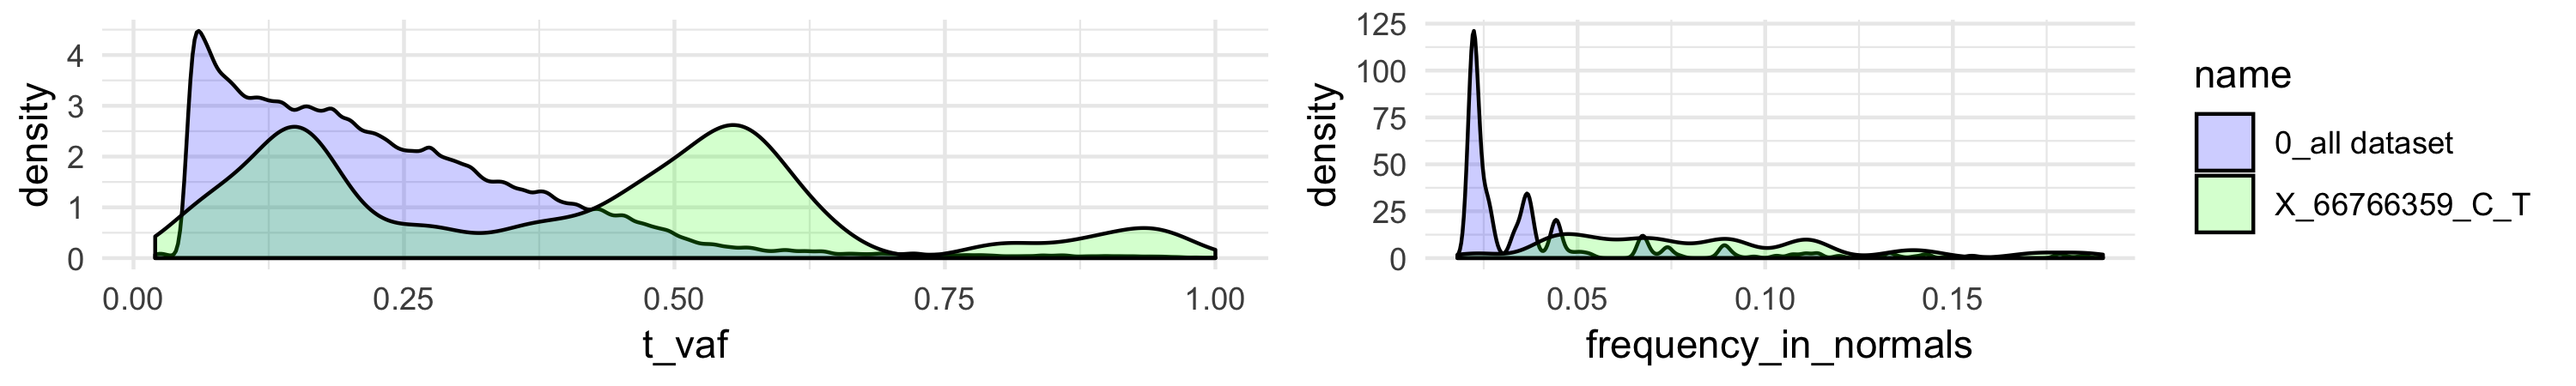

In [55]:
get_mutation_info(impact_syn, outliers$mut_key[1], plots = TRUE)

`t_vaf`$\approx$`0.5` and high `frequency_in_normals`, `Kaviar_AF` not null, probably germline.

Warning message:
“Groups with fewer than two data points have been dropped.”

count Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF cosmic_count
1 22    ATRX        X          c.4362A>G   p.E1454E    0         0

[1] "frequency_in_normals:"
 [1] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
[13] 0.000 0.000 0.000 0.000 0.000 0.037 0.000 0.000 0.000 0.000


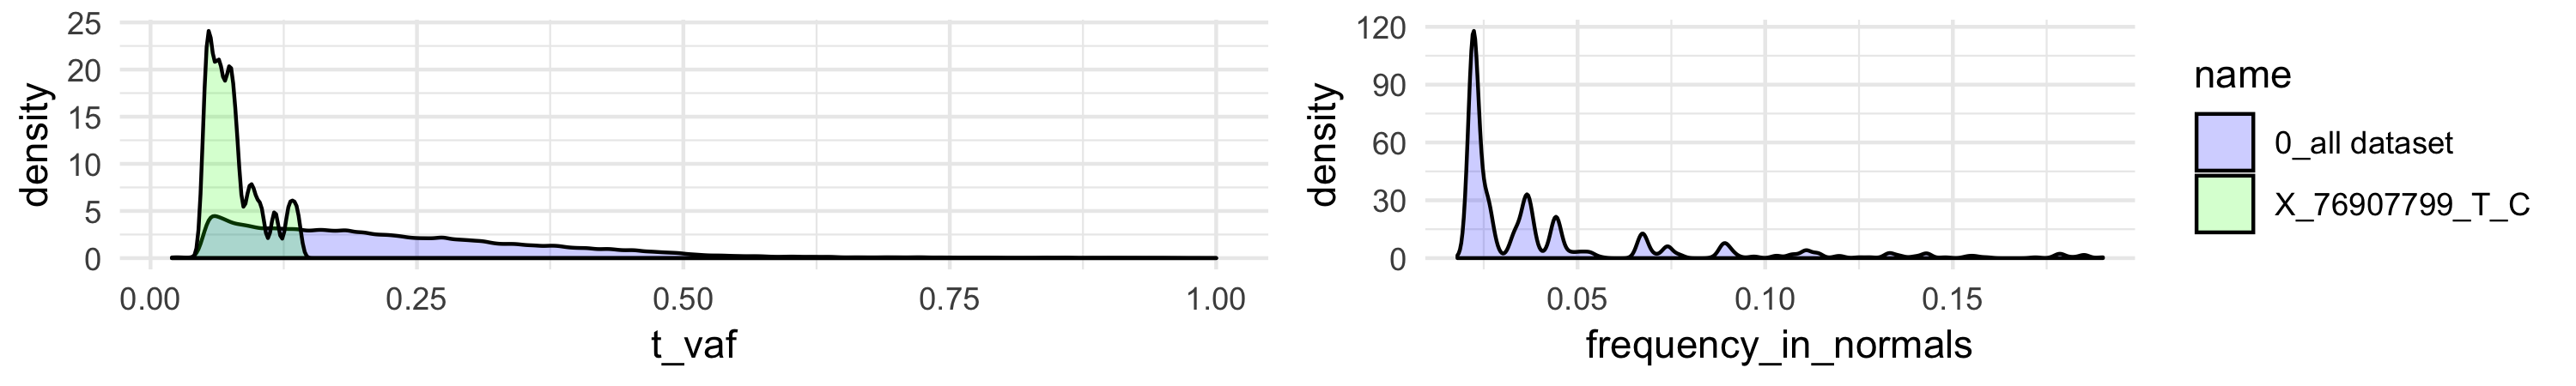

In [74]:
get_mutation_info(impact_syn, outliers$mut_key[10], plots = TRUE)
print("frequency_in_normals:")
print(impact_syn$frequency_in_normals[impact_syn$mut_key == outliers$mut_key[10]])

count Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF cosmic_count
1 20    ARID1B      6          c.363A>G    p.Q121Q     0.0004657 0

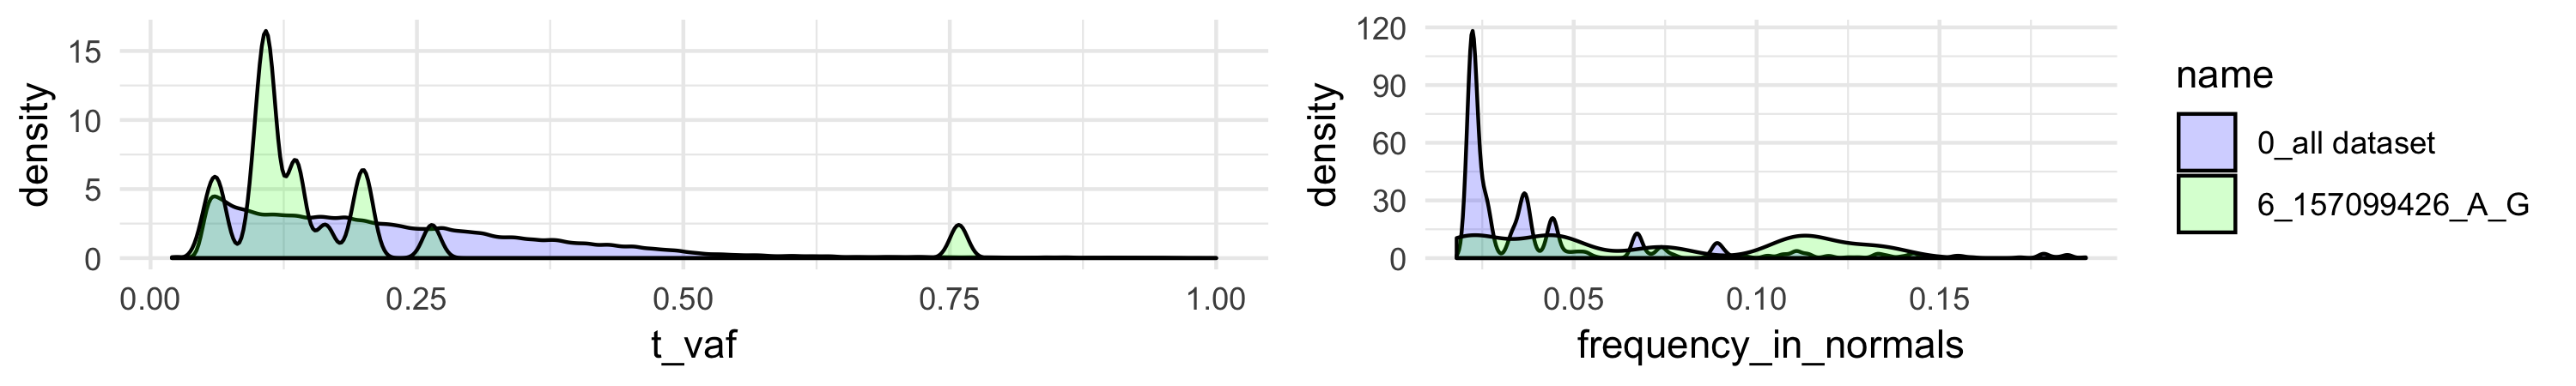

In [59]:
get_mutation_info(impact_syn, outliers$mut_key[13], plots = TRUE)

#### Rows 2 and 3

This two synonymous mutations are acting on the same 3-bp. See the non-null `cosmic_count` (https://cancer.sanger.ac.uk/cosmic/search?q=TP53%2C+T125T).

count Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF cosmic_count
1 36    TP53        17         c.375G>A    p.T125T     6.5e-06   18

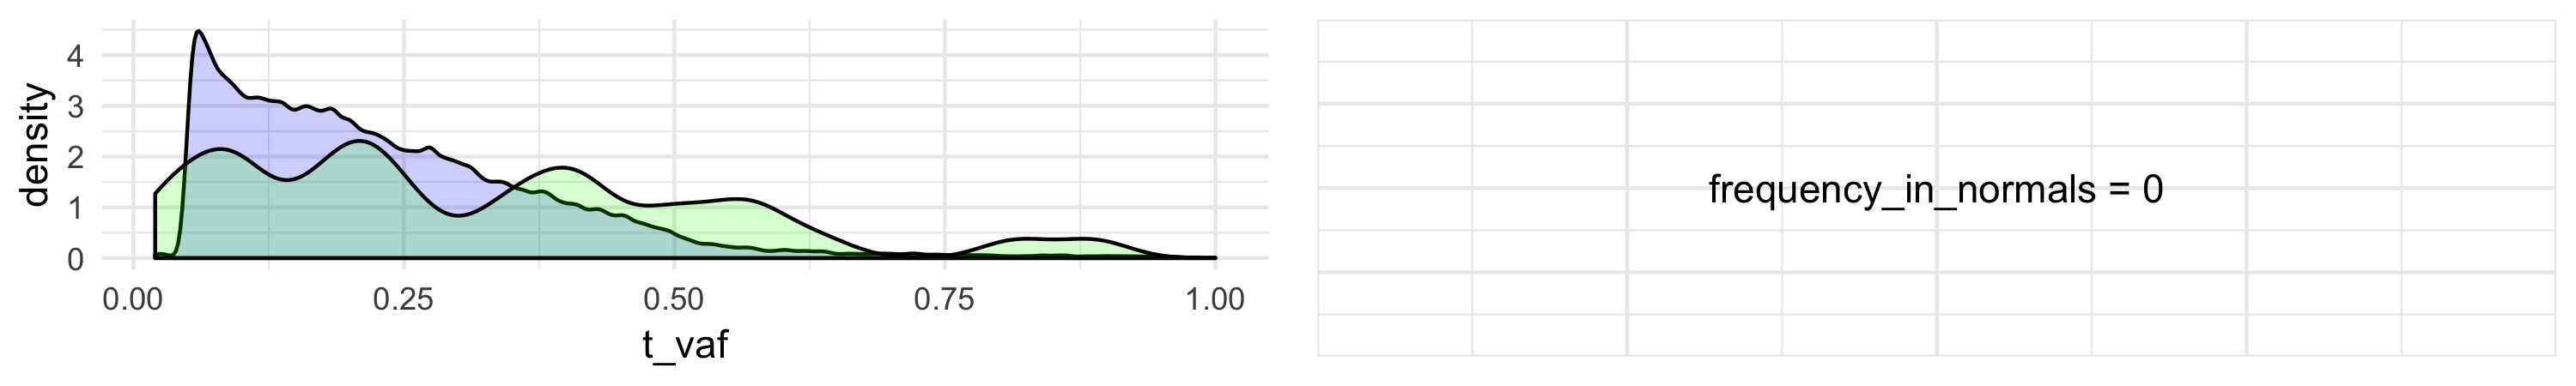

count Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF cosmic_count
1 35    TP53        17         c.375G>T    p.T125T     6.5e-06   17

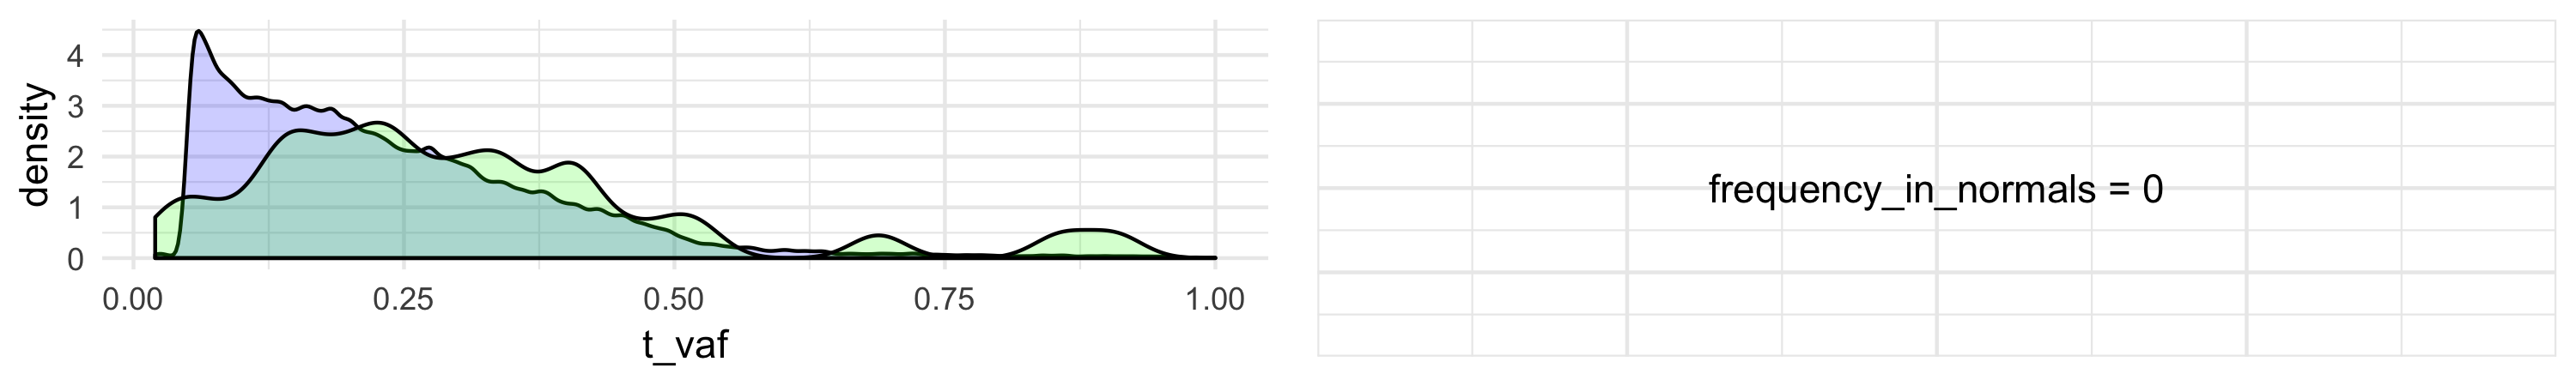

In [75]:
get_mutation_info(impact_syn, outliers$mut_key[2], plots = TRUE)
get_mutation_info(impact_syn, outliers$mut_key[3], plots = TRUE)

#### Outliers in gene `SDHA`

24 patients are concerned with these high reccurences in `SDHA`:

In [78]:
patients_concerned <- unique(impact_syn$patient_id[impact_syn$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "SDHA"]])
length(patients_concerned)
patients_concerned

[1] 24

[1] "P-0016594" "P-0016853" "P-0016922" "P-0016945" "P-0018570" "P-0018600"
 [7] "P-0018613" "P-0018627" "P-0018657" "P-0018659" "P-0018697" "P-0018696"
[13] "P-0018690" "P-0018693" "P-0018708" "P-0018709" "P-0018757" "P-0018794"
[19] "P-0018832" "P-0018833" "P-0018839" "P-0018845" "P-0018867" "P-0018900"

The patients do not have any other mutation in this gene (except 2 for 2 different patients):

In [79]:
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9)

impact[impact$patient_id %in% patients_concerned &
       impact$Hugo_Symbol == "SDHA" &
       ! impact$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "SDHA"],]

Hugo_Symbol Chromosome Start_Position End_Position Consequence      
153196 SDHA        5          235367         235367       synonymous_SNV   
153320 SDHA        5          235339         235339       nonsynonymous_SNV
       Variant_Type Reference_Allele Tumor_Seq_Allele2 Tumor_Sample_Barcode
153196 SNP          T                G                 P-0018696-T01-IM6   
153320 SNP          G                T                 P-0018693-T01-IM6   
       cDNA_change ⋯ confidence_class sample_coverage mut_key     
153196 c.1173T>G   ⋯ UNKNOWN           88             5_235367_T_G
153320 c.1145G>T   ⋯ AUTO_OK          346             5_235339_G_T
       sample_mut_key                 frequency_in_normals Kaviar_AF
153196 P-0018696-T01-IM6_5_235367_T_G 0                    0        
153320 P-0018693-T01-IM6_5_235339_G_T 0                    0        
       cosmic_count label          strand_ratio patient_id
153196 0            synonymous     0.4444444    P-0018696 
153320 0            coding_somatic 0.7931034    P-0018693

In [80]:
dd <- data.frame()
for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    dd <- rbind(dd, get_mutation_info(impact, outliers$mut_key[id], plots = FALSE))

dd

count Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF cosmic_count
1 25    SDHA        5          c.1203T>G   p.P401P     0         0           
2 24    SDHA        5          c.1209C>G   p.L403L     0         0           
3 24    SDHA        5          c.1212C>G   p.P404P     0         0           
4 23    SDHA        5          c.1206C>T   p.V402V     0         0           
5 23    SDHA        5          c.1221T>C   p.H407H     0         0           
6 23    SDHA        5          c.1224T>C   p.Y408Y     0         0           
7 22    SDHA        5          c.1188G>C   p.T396T     0         0           
8 21    SDHA        5          c.1185C>G   p.V395V     0         0

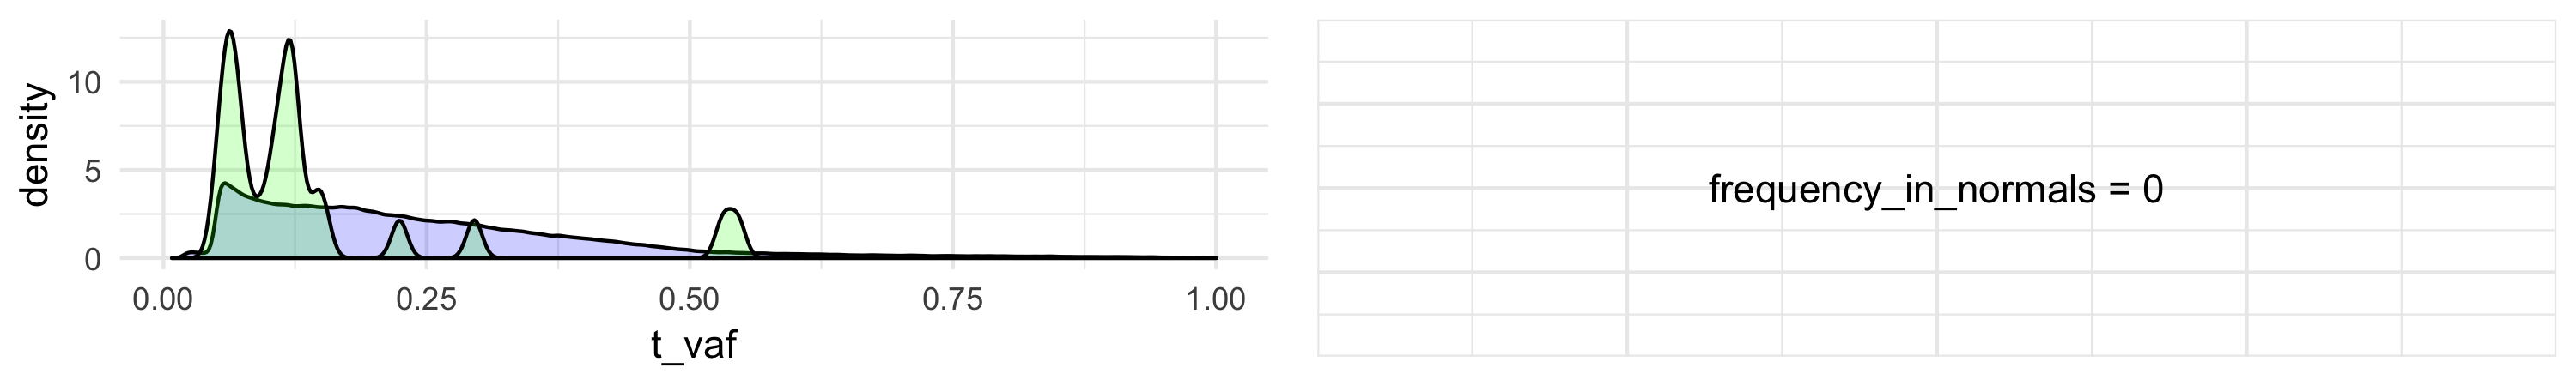

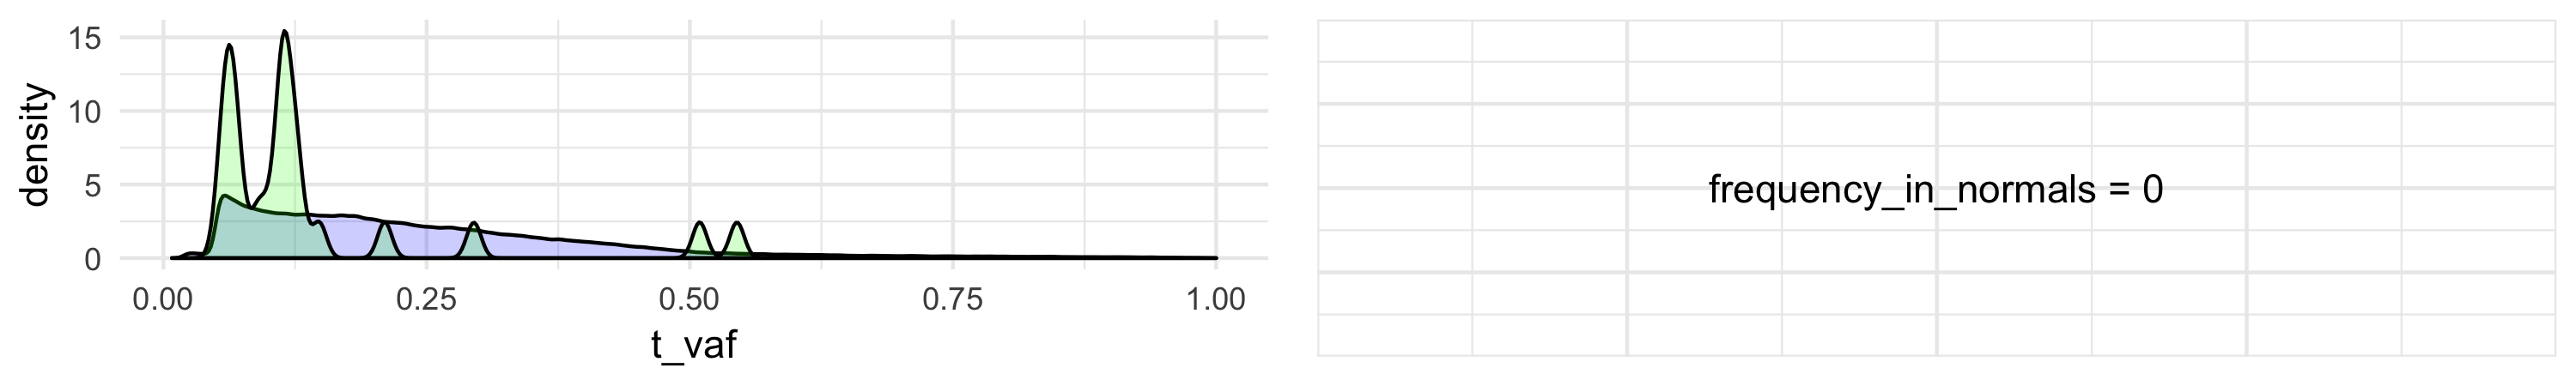

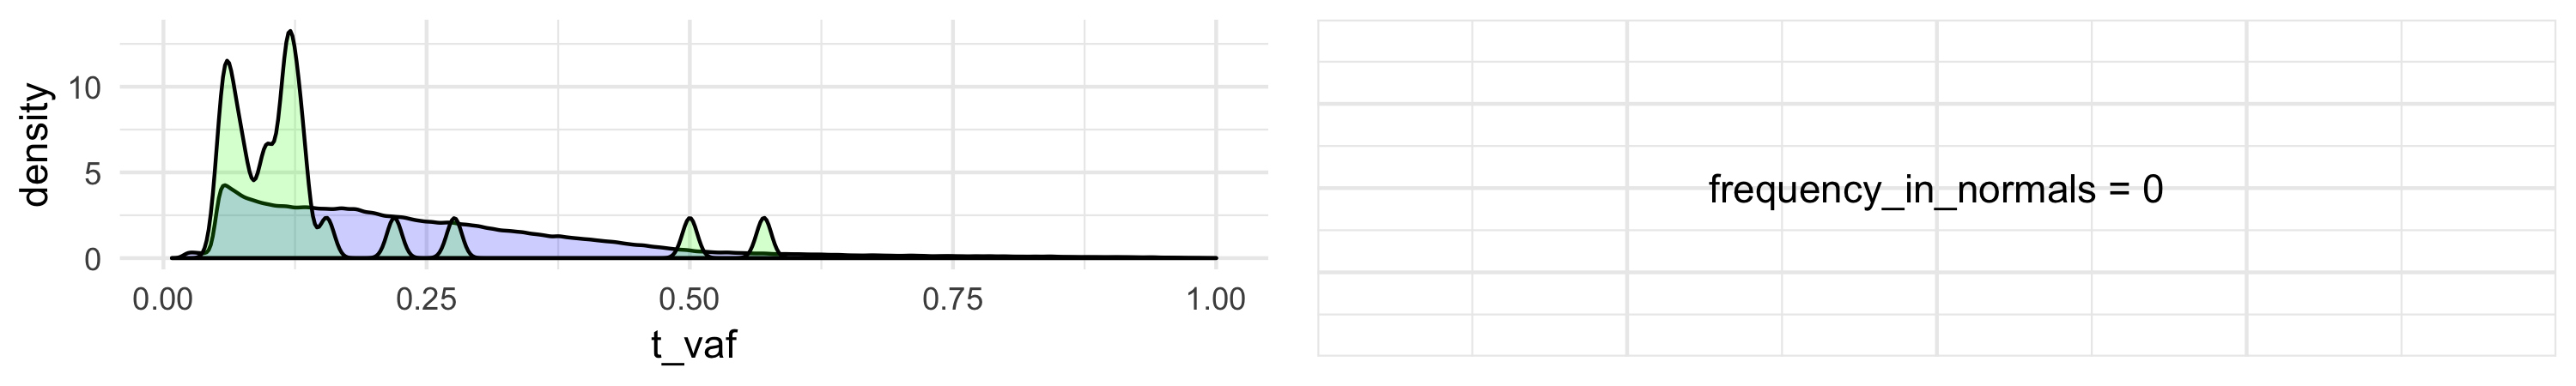

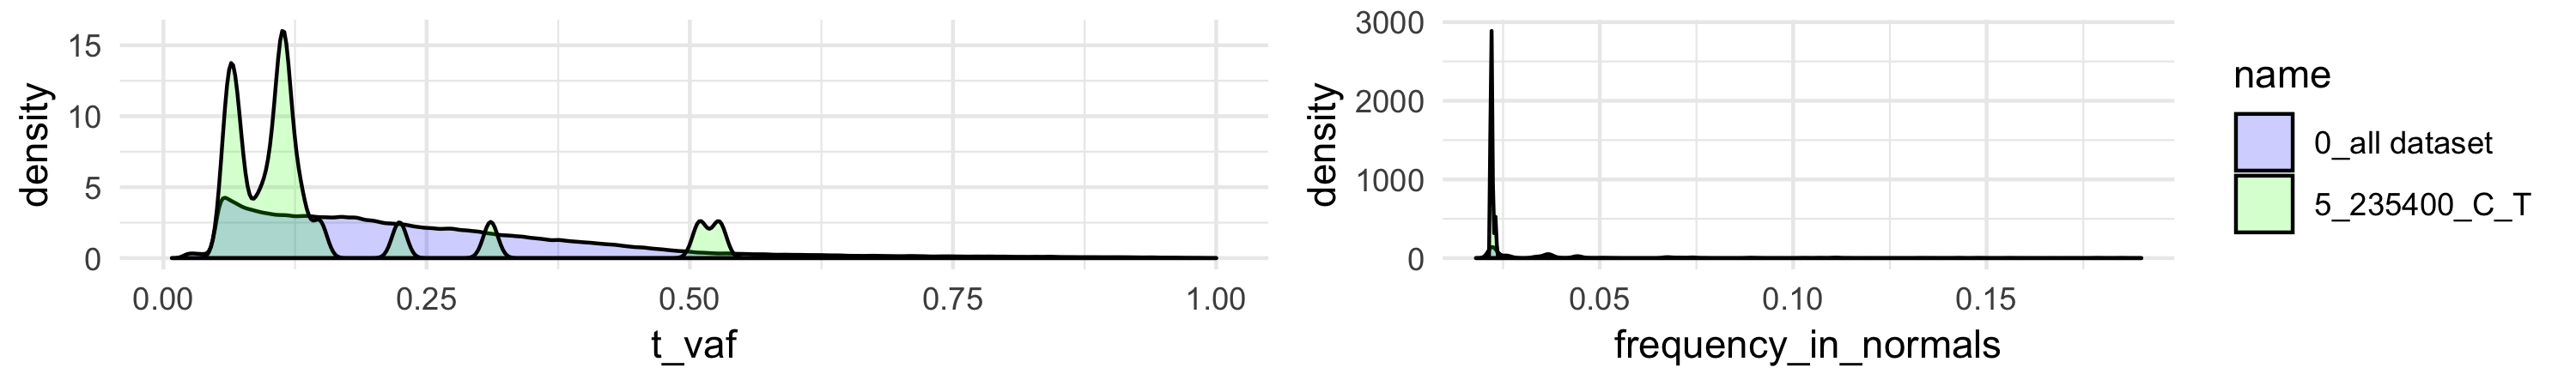

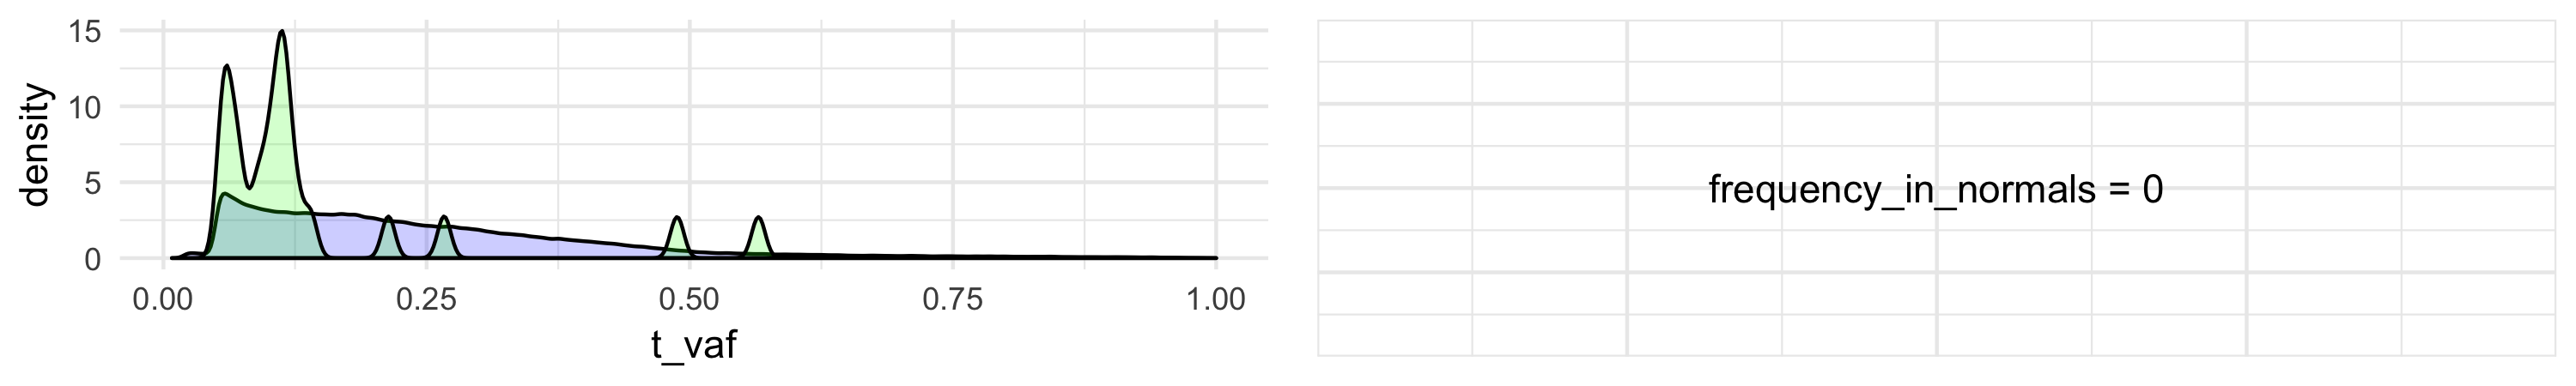

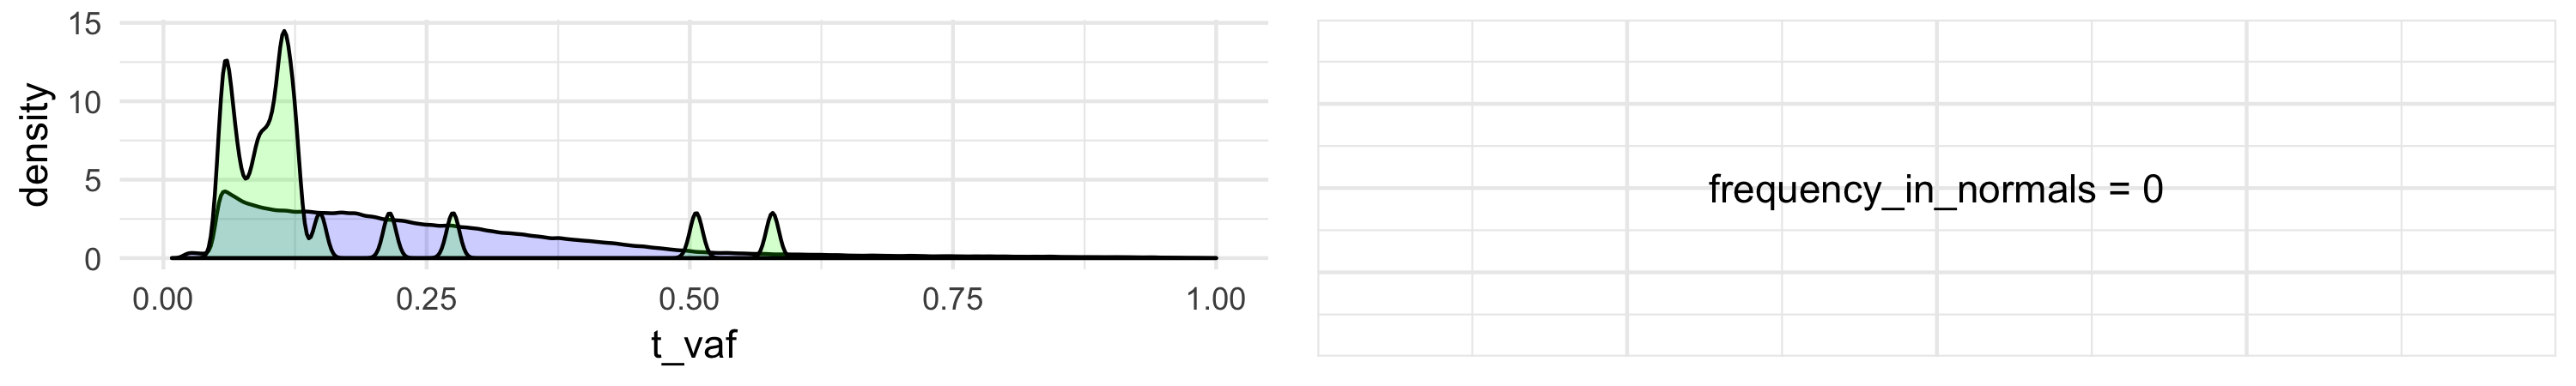

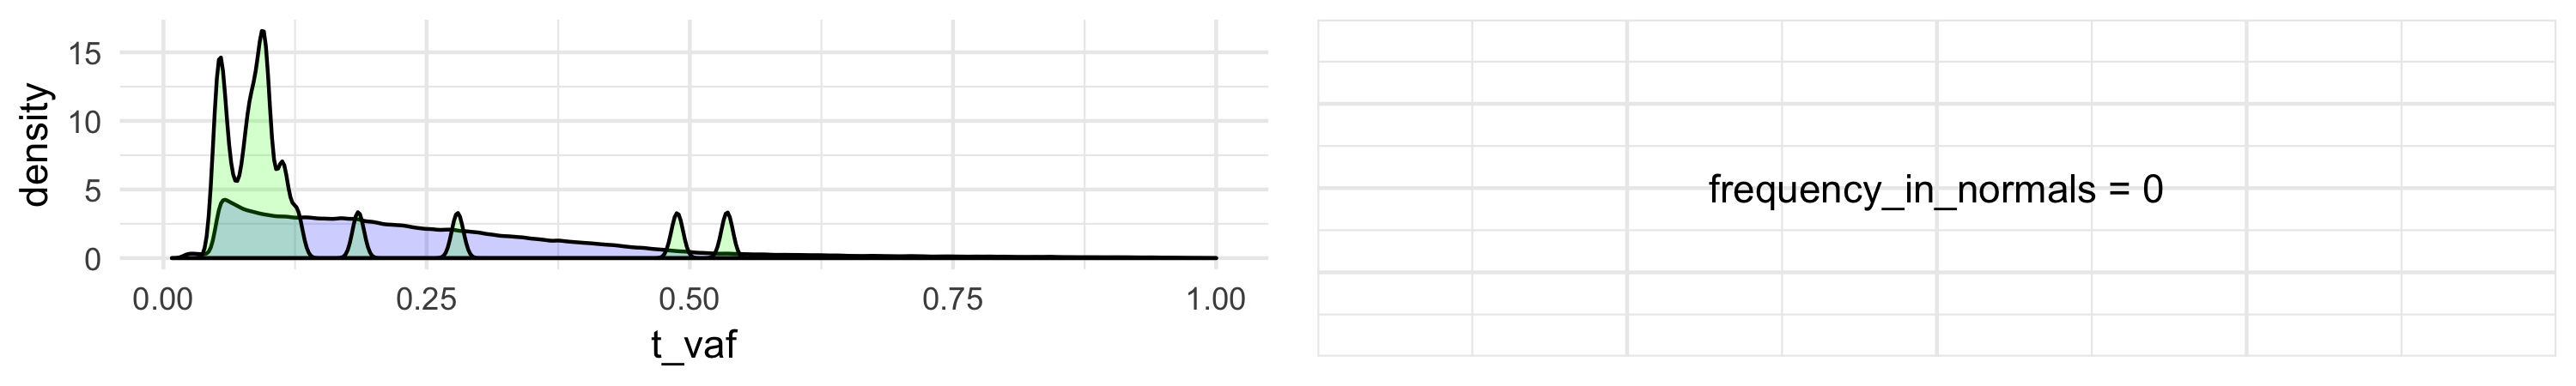

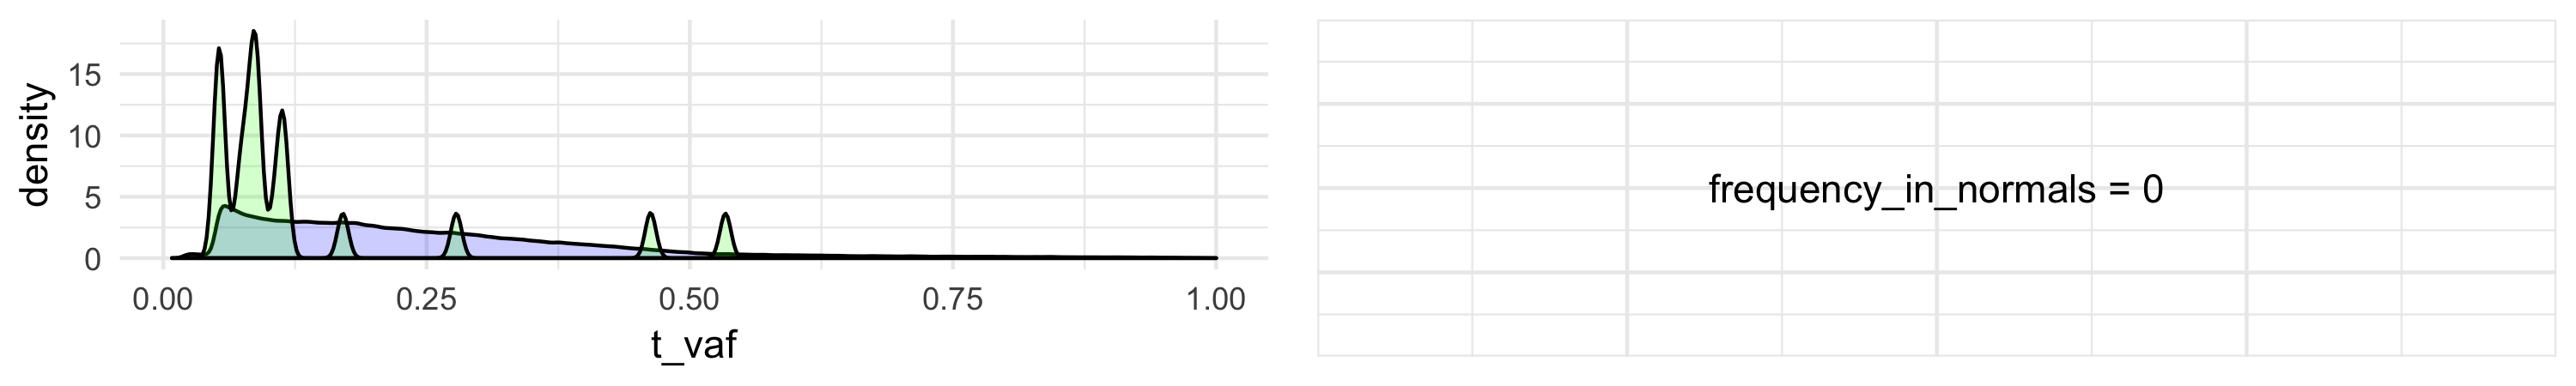

In [81]:
for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    get_mutation_info(impact, outliers$mut_key[id], plots = TRUE)

Found in COSMIC:  
https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=3615231  
https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=1067099  
https://cancer.sanger.ac.uk/cosmic/mutation/overview?id=1067099

In [100]:
dd <- table(impact$Hugo_Symbol[impact$patient_id %in% patients_concerned])
dd[dd >= 5]


    APC  GRIN2A PIK3C2G    SDHA SMARCA4    TP53 
      6       7       6     187       5      12 

In [91]:
impact <- add_features("../../../data/", impact, oncokb = TRUE)

In [95]:
table(impact$oncogenic[impact$patient_id %in% patients_concerned])


       Inconclusive      Likely Neutral    Likely Oncogenic           Oncogenic 
                  1                   1                  46                  14 
Predicted Oncogenic             Unknown 
                  3                 459 

In [105]:
impact[impact$patient_id %in% patients_concerned & impact$oncogenic != "Unknown",]

Hugo_Symbol Chromosome Start_Position End_Position
137626 EGFR        7           55211080       55211080   
151624 TP53        17           7579528        7579528   
151844 SMARCA4     19          11141492       11141492   
151857 CBL         11         119149242      119149242   
151887 NF1         17          29533389       29533390   
151888 NF1         17          29654858       29654858   
151891 SMARCA4     19          11152053       11152055   
151960 RAD51C      17          56801449       56801451   
151992 TP53        17           7577570        7577570   
151994 APC         5          112174574      112174574   
152515 TP53        17           7578461        7578461   
152516 HRAS        11            533875         533875   
152517 FOXA1       14          38060780       38060797   
152528 FOXP1       3           71015172       71015179   
152899 ANKRD11     16          89349146       89349146   
153164 BRAF        7          140453136      140453136   
153207 PIK3CA      3          178952085      178952085   
153208 SF3B1       2          198266834      198266834   
153209 TP53        17           7577559        7577559   
153250 TP53        17           7574012        7574012   
153269 TET1        10          70406258       70406258   
153281 LATS2       13          21619822       21619822   
153283 BRCA2       13          32929017       32929017   
153287 DICER1      14          95590564       95590564   
153293 GRIN2A      16           9858433        9858433   
153308 BARD1       2          215593633      215593633   
153313 PIK3CB      3          138413743      138413743   
153330 PTPRD       9            8376672        8376672   
153331 CDKN2A      9           21971110       21971110   
153333 RBM10       X           47045696       47045697   
⋮      ⋮           ⋮          ⋮              ⋮           
153570 PTEN        10          89711877       89711892   
153571 TP53        17           7579310        7579310   
153878 TP53        17           7578406        7578406   
153880 APC         5          112116592      112116592   
153881 SMAD2       18          45368202       45368202   
153882 KRAS        12          25398281       25398281   
153883 APC         5          112175153      112175153   
153884 FOXP1       3           71101750       71101751   
153894 ELF3        1          201984408      201984409   
154201 PIK3CA      3          178936091      178936091   
154202 RHOA        3           49412973       49412973   
154211 CBFB        16          67100661       67100661   
154214 KMT2C       7          151873934      151873934   
154220 TP53        17           7578394        7578394   
154234 CDKN2A      9           21971048       21971060   
154356 EIF1AX      X           20156731       20156731   
154394 KRAS        12          25398285       25398285   
154409 KEAP1       19          10610436       10610436   
154410 SMARCA4     19          11172459       11172459   
154729 TP53        17           7577124        7577124   
154732 RB1         13          48954379       48954379   
154744 AXIN1       16            343522         343522   
154746 AXIN2       17          63554616       63554626   
154806 TP53        17           7577124        7577124   
154816 MED12       X           70360630       70360630   
159320 ANKRD11     16          89349146       89349146   
175840 KRAS        12          25398284       25398284   
175841 FBXW7       4          153247366      153247366   
175842 RNF43       17          56492854       56492854   
175846 KMT2B       19          36228979       36228979   
       Consequence            Variant_Type Reference_Allele   Tumor_Seq_Allele2
137626 nonsynonymous_SNV      SNP          G                  A                
151624 stopgain_SNV           SNP          C                  T                
151844 nonsynonymous_SNV      SNP          C                  T                
151857 nonsynonymous_SNV      SNP          C                  T                
151887 spli